Energy estimation using Random Forest Regression with or w/o using sample weights on events while training.

In [17]:
import glob
import numpy
import sys, os
import tables
import pickle
from decimal import Decimal
from scipy.optimize import curve_fit

from sklearn.externals import joblib
import sklearn
from sklearn import metrics
import sklearn.ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
#sys.path.append('/Users/ramesh/GoogleDrive/LowEnergy/RandomForest')
#from rfpimp import *

import matplotlib
import matplotlib.backends.backend_pdf
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
%matplotlib inline

params = {'legend.fontsize': 18,
          'axes.labelsize': 22,
          'axes.titlesize':23,
          'xtick.labelsize':20,
          'ytick.labelsize':20,
          'figure.figsize':(10, 8),
          'axes.grid':True}
plt.rcParams.update(params)


In [2]:
print "All required Functions"
def rotate_to_shower_cs(x,y,z,time,phi,theta,core_x,core_y,core_z,core_time):
    """ Input: X,Y,Z of the dom/particle; Phi, Theta, Core x,y ,z of the shower.                                                                             
        Output: Radial distance from shower core in shower coordinate system."""
    import numpy
    # counter-clockwise (pi + phi) rotation                                                                                                                  
    d_phi    = numpy.matrix([ [ -numpy.cos(phi), -numpy.sin(phi), 0],
                              [  numpy.sin(phi), -numpy.cos(phi), 0],
                              [  0,               0,              1]])
    # clock-wise (pi - theta) rotation                                                                                                                       
    d_theta  = numpy.matrix([ [  -numpy.cos(theta), 0, -numpy.sin(theta)],
                              [  0,                 1,  0,              ],
                              [  numpy.sin(theta),  0, -numpy.cos(theta)]])
    rotation = d_theta*d_phi

    origin   = numpy.array([[core_x], [core_y], [core_z]])

    det_cs_position    = numpy.array([[x],[y],[z]])
    shower_cs_position = rotation*(det_cs_position - origin)
    shower_cs_radius   = numpy.sqrt(shower_cs_position[0]**2 + shower_cs_position[1]**2)
    #Delta_time         = time - (core_time + (shower_cs_position[2]/3.0e8)*1.e9 + top_curv_gausspar(shower_cs_radius)) # time in ns. Gausspar fit.          
    Delta_time         = time - (core_time + (shower_cs_position[2]/3.0e8)*1.e9) # time in ns. Plane fit                                                     

    #print Delta_time, time, core_time, shower_cs_position[2]
    
    return numpy.float(shower_cs_radius), numpy.float(Delta_time)

def gaussian(x, a, b, c):
    # Gaussian function to be used for getting mean and sigma of energy distribution.
    c = abs(c)
    return a*numpy.exp(-(x-b)**2/(2*c*c))

def weighted_std(values, weights):
    """
    Return the weighted average and standard deviation.
    values, weights -- Numpy ndarrays with the same shape.
    """
    average  = numpy.average(values, weights=weights)
    variance = numpy.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return numpy.sqrt(variance)

def sigmoid_func(x, p0, p1, p2):
    return p0/(1 + numpy.exp(-p1*(x-p2))) # bhaktiyar sigmoid

def time_func(t, I0, tau):
    return I0*numpy.exp(-t/tau)

def livetime(time_array):
    from scipy.optimize import curve_fit
    
    time_bins       = numpy.linspace(0,2, 153)
    sort_time       = numpy.sort(time_array)
    time_difference = numpy.diff(sort_time)
    timey,x         = numpy.histogram(time_difference, bins=time_bins)
    popt, pcov      = curve_fit(time_func, time_bins[:-1], timey, p0=[timey[0], 0.1])

    N          = sum(timey)
    tau        = popt[1]
    duration   = N*tau
    print ''
    print 'popt', popt[0], popt[1]
    print 'Covariance', pcov
    print 'N: ', N
    print 'Tau: ', tau, 's'
    print 'Duration: ', 'N*Tau: ', N*tau, 's,', (N*tau)/(24*60*60.), 'days'
    print ''
    return duration

def time_between_events(time_array):
    from scipy.optimize import curve_fit
    
    time_bins       = numpy.arange(0,5, 0.0133333)
    sort_time       = numpy.sort(time_array)
    time_difference = numpy.diff(sort_time)
    timey,x         = numpy.histogram(time_difference, bins=time_bins)

    return timey

def it_geometry():
    i3f = dataio.I3File('/Users/ramesh/GoogleDrive/LowEnergy/geometry.i3.gz')
    frame = i3f.pop_frame()

    geometry = frame['I3Geometry']

    tank_positions={}
    for k in geometry.stationgeo.keys(): # _geometry.stationgeo.keys() = [1,2,3,4, ....., 80,81]                                                          
	tank_positions[k]={'A':[geometry.stationgeo[k][0].position.x,
                            geometry.stationgeo[k][0].position.y,
                            geometry.stationgeo[k][0].position.z],
                       'B':[geometry.stationgeo[k][1].position.x,
                            geometry.stationgeo[k][1].position.y,
                            geometry.stationgeo[k][1].position.z]}

    i3f.close()
    del i3f
    del frame
    del k

    return tank_positions

def ldf(r, S60, beta):
    return S60*((r/60.)**(-beta-0.303*numpy.log10(r/60.)))

def eproxy_func(x,a,b, c, d):
    return a + (b*x) + (c*x**2) + (d*x*x*x)


# percentage increase is:
# x = logQtotal
#      at x=0, Qhillas > 50% of Qtotal
#      at x=1, Qhillas > 10% of Qtotal
#      at x=2, Qhillas > 5% of Qtotal
#      at x=3, Qhillas > 6% of Qtotal
def balloon_cut(x):
    return 0.2*x*x + 0.1*x - 0.3

def errorXbyY(X, Y, errX, errY):
    import numpy
    error = numpy.sqrt((errX/Y)**2 + (X*errY/(Y**2))**2)
    return error

def midBins(loge_bins, ind):
    # ind is integral_index i.e 1.65, differential index is 2.65
    lnE_bins = loge_bins/numpy.log10(numpy.exp(1))
    a        = lnE_bins[:-1]
    b        = lnE_bins[1:]
    mid = -1.*(numpy.log((numpy.exp(-ind*a) - numpy.exp(-ind*b))/(ind*(b-a)))/ind)
    return numpy.log10(numpy.exp(1))*mid

def efficiency(logEnergy, Weight, 
               loge_bins, 
               particle='all', 
               composition_model='h4a'):
    """
    Efficiency for input logenergy after all quality cuts. Energy can be both True or Reconstructed.
    """
    wtNgenerated, Ngen_err, num_evt_gen = weighted_Ngenerated(particle=particle, composition_model=composition_model)
    wtNtrue   = numpy.histogram(logEnergy, bins=loge_bins, weights=Weight)[0]
    Ntrue_err = numpy.sqrt(numpy.histogram(logEnergy, bins=loge_bins, 
                                           weights=(Weight*Weight))[0])
    error_eff = numpy.sqrt((Ntrue_err/wtNgenerated)**2 + (wtNtrue*Ngen_err/(wtNgenerated**2))**2)
    eff       = wtNtrue/wtNgenerated
    
    return eff, error_eff

def effective_area(eff, loge_bins, fitted=False):
    # This works both for effective area and its error.
    # Input: Efficiency, or Error on efficiency.
    
    truncated_bins = loge_bins[:-1] 
    if isinstance(eff, (numpy.ndarray, list)):
        pass
    elif isinstance(eff, (float, int)):
        eff = numpy.ones(len(truncated_bins)) * eff 

    RSim45 = 200.
    RSim56 = 400.
    RSim67 = 600.
    RSim78 = 800.

    AreaSim45 = numpy.pi*RSim45*RSim45
    AreaSim56 = numpy.pi*RSim56*RSim56
    AreaSim67 = numpy.pi*RSim67*RSim67
    AreaSim78 = numpy.pi*RSim78*RSim78

    mask45 = (truncated_bins>=4)*(truncated_bins<5)
    mask56 = (truncated_bins>=5)*(truncated_bins<6)
    mask67 = (truncated_bins>=6)*(truncated_bins<7)
    mask78 = (truncated_bins>=7)*(truncated_bins<8)

    Aeff         = numpy.zeros(len(eff))
    Aeff[mask45] = AreaSim45*(eff[mask45])
    Aeff[mask56] = AreaSim56*(eff[mask56])
    Aeff[mask67] = AreaSim67*(eff[mask67])
    Aeff[mask78] = AreaSim78*(eff[mask78])
    
    if fitted:
        mid_logE = 0.5*(loge_bins[1:]+loge_bins[:-1])
        effx = numpy.linspace(min(mid_logE),max(mid_logE),501)
        init = [max(Aeff), 5., 5.]
        mask = (mid_logE>=5.4)*(mid_logE<=7.0)
        popt, pcov = curve_fit(sigmoid_func, mid_logE[mask], Aeff[mask], 
                                 p0=init, sigma=ErrAeff[mask])
        Aeff               = sigmoid_func(mid_logE, *popt)
        return Aeff, popt

    else:
        return Aeff

def cr_flux(
        logene_spectrum, 
        error_logene_spectrum,
        loge_bins=numpy.linspace(4,7.6,19), 
        scale=1, 
        Aeff=1,
        errAeff=1,
        cos1=1, cos2=0.9
        ):
    mid_logE = 0.5*(loge_bins[1:]+loge_bins[:-1])
    lnE      = loge_bins/numpy.log10(numpy.exp(1))
    dlnE     = numpy.diff(lnE)
    exposure       = Aeff*numpy.pi*((cos1**2) - (cos2**2))
    scaling_factor = (10**(mid_logE))**(scale-1)
    flux           = (scaling_factor*logene_spectrum)/(dlnE*exposure)
    # Error calculation is a bit tricky. Both logene_spectrum and Aeff has its own error.
    error          = errorXbyY(logene_spectrum, Aeff, error_logene_spectrum, errAeff)
    error_flux     = error/(dlnE*numpy.pi*((cos1**2) - (cos2**2)))

    return flux, error_flux

def logS125_to_logE(logS125, a, b):
    # 0.90603644, 6.04892767 # fitted here
    # 0.933316,   6.010569   # Kath's 3yr spectrum
    return (a*logS125) + b

def distance(x1, y1, x2, y2):
    dist = numpy.sqrt((x1-x2)**2 + (y1-y2)**2)
    return dist
    
def feature_importance_dict(permutation_feature, featuresname, n):
    permutation_feature[permutation_feature<0]=0
    permutation_feature = permutation_feature/sum(permutation_feature)
    
    feature_importance = {}
    for feature in featuresname:
        feature_importance[feature] = []

    i = 0
    # feature_importance = {'lNtanks':[val1, val2, val3, ..val_kfold], 'lQhillas':[....], ...}
    for feature in featuresname:
        for j in range(len(models)):
            if feature=='lPul':
                feature_importance[feature].append(sum(permutation_feature[i:i+n]))
            elif feature=='logR':
                feature_importance[feature].append(sum(permutation_feature[i:i+n]))
            else:
                feature_importance[feature].append(permutation_feature[i])

        if feature=='lPul':
            i += n
        elif feature=='logR':
            i += n
        else:
            i += 1

    return feature_importance

All required Functions


In [3]:
print 'Analysis class'
class Analysis(object):

    def __init__(self):
        self.angle_bins    = numpy.linspace(0,60,121)
        self.beta_bins     = numpy.linspace(-3., 10., 66)
        self.chi2_bins     = numpy.linspace(0, 50, 501)
        self.core_bins     = numpy.linspace(1,80,80)
        self.cos_bins      = numpy.linspace(0.8,1., 5)
        self.cosz_bins     = numpy.linspace(0.4, 1, 81)
        self.coreres_bins  = numpy.linspace(0,100,101)
        self.charge_bins   = numpy.logspace(-1, 4, 51)
        self.distance_bins = numpy.linspace(0, 600, 601)
        self.energy_dir    = numpy.linspace(4.0, 7, 31) #linspace 
        self.ene_bins      = numpy.logspace(4.0,7.6,19)   #logspace
        self.eneres_bins   = numpy.linspace(-2,2,41)
        self.position_bins = numpy.linspace(-600, 600, 241)
        self.ndf_bins      = numpy.linspace(0, 162, 163)
        self.qtotal_bins   = numpy.logspace(-1, 5, 61)
        self.s60_bins      = numpy.logspace(-1, 4, 51)
        self.station_bins  = numpy.linspace(0, 90, 91)
        self.tank_bins     = numpy.linspace(0, 162, 163)   # total num of tanks = 162           
        
        self.particle_dict_h = {'proton': '10410',
                                'helium': '11663',
                                'oxygen': '12605',
                                'iron'  : '10889'}
        self.particle_dict_l = {'proton': '9508',
                                'helium': '7362',
                                'oxygen': '7364',
                                'iron'  : '9614'}

    def angle_betn_two_vectors(self, true_zenith, true_azimuth, reco_zenith, reco_azimuth):
        # Find unit vector with given zenith and azimuth.                             
        truex = numpy.sin(true_zenith)*numpy.cos(true_azimuth)
        truey = numpy.sin(true_zenith)*numpy.sin(true_azimuth)
        truez = numpy.cos(true_zenith)
        recox = numpy.sin(reco_zenith)*numpy.cos(reco_azimuth)
        recoy = numpy.sin(reco_zenith)*numpy.sin(reco_azimuth)
        recoz = numpy.cos(reco_zenith)
        V1    = numpy.array([truex, truey, truez])
        V2    = numpy.array([recox, recoy, recoz])
        magV1 = numpy.sqrt((V1[0])**2 + (V1[1])**2 + (V1[2])**2)
        magV2 = numpy.sqrt((V2[0])**2 + (V2[1])**2 + (V2[2])**2)
        cos_theta = ((V1[0])*(V2[0]) + (V1[1])*(V2[1]) + (V1[2])*(V2[2]))/(magV1 * magV2)
        angle = numpy.rad2deg(numpy.arccos(cos_theta))

        return angle

    def circular_containment(self, core_x, core_y, cont_radius=45.):
        '''
        tank_positions = {26: {'A': [13.460000038146973, -129.35499572753906],
                               'B': [20.950000762939453, -135.9149932861328]},                       
                          36: {'A': [37.435001373291016, -57.36000061035156],                   
                               'B': [29.18000030517578, -52.80500030517578]},                        
                          46: {'A': [71.3499984741211, 66.82499694824219],                      
                               'B': [67.07500076293945, 75.39500045776367]},                         
                          79: {'A': [18.09999942779541, -94.63000106811523],                    
                               'B': [10.880000114440918, -87.69499969482422]},                       
                          80: {'A': [76.42499923706055, -42.47999954223633],                    
                               'B': [85.64500045776367, -46.0]},                                     
                          81: {'A': [77.40999984741211, 37.6150016784668],                      
                               'B': [87.19000244140625, 39.84000015258789]}                          
                      }
        '''
        x = numpy.array([13.460000038146973, 20.950000762939453, 37.435001373291016, 29.18000030517578, 71.3499984741211, 
                         67.07500076293945,  18.09999942779541,  10.880000114440918, 76.42499923706055, 85.64500045776367, 
                         77.40999984741211, 87.19000244140625])
        y = numpy.array([-129.35499572753906, -135.9149932861328, -57.36000061035156, -52.80500030517578, 66.82499694824219, 
                         75.39500045776367,   -94.63000106811523, -87.69499969482422, -42.47999954223633, -46.0, 
                         37.6150016784668, 39.84000015258789])

        boolean = numpy.array(len(core_x)*[False])
        for i in range(len(x)):
            x1 = x[i] - core_x
            y1 = y[i] - core_y
            distance = numpy.sqrt(x1*x1 + y1*y1)
            boolean = numpy.logical_or(boolean, (distance<=cont_radius))
            
        return boolean

    def directional_histogram(self, true_zenith, true_azimuth, reco_zenith, reco_azimuth, weights=None):
        # Find unit vector with given zenith and azimuth.    
        truex = numpy.sin(true_zenith)*numpy.cos(true_azimuth)
        truey = numpy.sin(true_zenith)*numpy.sin(true_azimuth)
        truez = numpy.cos(true_zenith)
        recox = numpy.sin(reco_zenith)*numpy.cos(reco_azimuth)
        recoy = numpy.sin(reco_zenith)*numpy.sin(reco_azimuth)
        recoz = numpy.cos(reco_zenith)
        true_vec = numpy.array([truex, truey, truez])
        reco_vec = numpy.array([recox, recoy, recoz])
        angle = self.angle_betn_two_vectors(true_vec, reco_vec) # angle in deg
        angley, anglex = numpy.histogram(angle, bins=self.angle_bins, weights=weights) 
        # angle bins = 60 [0,1,2..61]

        return angley, anglex

    def polygonato_all(self):
        E          = self.ene_bins[:-1] + numpy.diff(self.ene_bins)/2.

        gamma = numpy.array([[1.71, 1.64, 1.67, 1.70, 1.55],
                             [1.40, 1.40, 1.40, 1.40, 1.40],
                             [1.40, 1.40, 1.40, 1.40, 1.40]])
        a     = numpy.array([[11800, 4750, 3860, 3120, 1080],
                             [11.8, 11.8, 7.88, 7.88, 7.88],
                             [1.7, 1.7, 1.14, 1.14, 1.14]])
        Z     = numpy.array([1, 2, 8, 14, 26])
        Rcut  = [4.49e6, 30e6, 2e9] #GV                                                                                                                                                
        flux_population = numpy.zeros(len(E))
        for par_indx in range(5):
            for j in range(3):
                flux = a[j][par_indx]*E**(-gamma[j][par_indx])*numpy.exp(-E/(Z[par_indx]*Rcut[j]))
                flux_population += flux

        return flux_population
    
analysis = Analysis()

Analysis class


In [4]:
print 'all bins'
angle_bins    = numpy.linspace(0,60,121)
core_bins     = numpy.linspace(1,80,80)
cos_bins      = numpy.linspace(0.8,1., 5)
cosz_bins     = numpy.linspace(0.4, 1, 81)
charge_bins   = numpy.logspace(-1, 4, 51)
distance_bins = numpy.linspace(0, 600, 601)
energy_dir    = numpy.linspace(4.0, 7.5, 36) #linspace 
ene_bins      = numpy.logspace(4.0,7.6,19)   #logspace
loge_bins     = numpy.linspace(4.0,7.6,19)
eneres_bins   = numpy.linspace(-2,2,41)
position_bins = numpy.linspace(-600, 600, 241)
s125_bins      = numpy.logspace(-1, 4, 51)
station_bins  = numpy.linspace(0, 90, 91)
tank_bins     = numpy.linspace(0, 162, 163)
sigmaleaf_bins = numpy.linspace(0,0.3,71)
cos_bins       = numpy.linspace(0.4,1,61)

mid_charge_bins = 0.5*(charge_bins[1:]+charge_bins[:-1])
mid_s125_bins = 0.5*(s125_bins[1:]+s125_bins[:-1])
mid_angle_bins = 0.5*(angle_bins[1:]+angle_bins[:-1])
mid_cosz_bins = 0.5*(cosz_bins[1:]+cosz_bins[:-1])
mid_tank_bins = 0.5*(tank_bins[1:]+tank_bins[:-1])
mid_station_bins = 0.5*(station_bins[1:]+station_bins[:-1])
mid_ene_bins     = 0.5*(ene_bins[1:]+ene_bins[:-1])
mid_logE         = 0.5*(loge_bins[1:]+loge_bins[:-1])

all bins


In [5]:
print "Steering File"
print "Select what option to pass."

# Order what to do!!!!!
particle           = 'all'    # 'proton', 'helium', 'oxygen', 'iron', 'all'
weight_or_noweight = 'weight' #'weight, noweight' # Train random forest with or without weight.
composition_model  = 'h4a'    # 'h4a', 'gst', 'poly', 'gsfL', 'gsfM', 'gsfH'

quality_cut_list   = ['loud_station', 
                      'balloon', 
                      'high_energy', 
                      'zenith']

# Values
cos1               = 0.95
cos2               = 0.80
Rref               = 60   # fracRadius = Radius/Rref
cont_radius        = 45    # Used only if containment_cut = True

# Boolean
do_experiment      = True
testrun            = False  # Use 10 experiment Run to calculate flux. This is faster and easy to test code.
savefig            = True
do_1d              = True
do_2d              = False
isqgsjet           = False

# PPlus, He4Nucleus, O16Nucleus , Fe56Nucleus. Used to get fraction of flux contributed by this particular particle.
pdgcode_dict       = {
                        'proton':2212,
                        'helium':1000020040,
                        'oxygen':1000080160,
                        'iron'  :1000260560
                     }      

# Link to a directory or a file
name        = '_paperS'#'_14mar2019' #'_23oct2018' #'' for sybill, '_qgsjet' for qgsjet, '_10dec2018'
hfreadfile  = '/Users/rameshkoirala/Documents/Paper/analysis_simulation_HLCCoreSeed_slcQcut_fracradius_final.h5'
lowEdir     = '/Volumes/RameshDrive/MacintoshHDcopy/Users/ramesh/GoogleDrive/LowEnergy/'

savedir     = '/Users/rameshkoirala/Documents/Paper/'
rfr_savedir = '/Users/rameshkoirala/Documents/Paper/Plot/'



Steering File
Select what option to pass.


In [29]:
# This file has all (H+He+O+Fe) MC events that 
if hfreadfile != '':
    print 'Reading HdfFile: ', hfreadfile
    hf = tables.open_file(hfreadfile)
    #Keys = ['S60' , 'Beta'  , 'Chi2'  , 'Qmax'  , 'Qhillas', 'Qtotal' , 'Qtotalhlc',       
    #         'Nslc', 'Ntanks', 'Tcorex', 'Tcorey', 'Rcorex' , 'Rcorey' , 'COGX'     ,
    #         'T0'  , 'Nsta'  , 'COGY'  , 'Tzenith','Tazimuth','Rzenith'  'Razimuth' , 
    #         'CoreDiff'  , 'AngleDiff', 'Energy'   , 'WeightPoly',  'WeightH4a', 
    #         'WeightGST' , 'FitStatus', 'FiltCondt','LoudSta'    , 'Contained' ,       
    #         'TankX'     , 'TankY'    , 'Pulses'   , 'HitsTime' 
    Tenergy    = hf.root.Energy[:]
    logPenergy = hf.root.PredictedLogEnergy_h4aOrig[:]
    maskene    = hf.root.maskTrainingEnergy[:]
    FiltCondt  = hf.root.FiltCondt[:]
    LoudSta    = hf.root.LoudSta[:]
    PDG        = hf.root.pdg_encoding[:]
    #----------------------------
    #Qhillas   = hf.root.Qhillas[:]
    #Qhillas[numpy.where(numpy.isnan(Qhillas))]=1e-10
    #Qtotal    = hf.root.Qtotal[:]
    #Qtotal[numpy.where(numpy.isnan(Qtotal))]=1e-10
    Qtotalhlc = hf.root.Qtotalhlc[:]
    #Qtotalhlc[numpy.where(numpy.isnan(Qtotalhlc))]=1e-10
    Nsta      = hf.root.Nsta[:]
    #----------------------------
    Tcorex    = hf.root.Tcorex[:]
    Tcorey    = hf.root.Tcorey[:]
    COGX      = hf.root.COGX[:]
    COGY      = hf.root.COGY[:]
    PredictedX= hf.root.PredictedX[:]
    PredictedY= hf.root.PredictedY[:]
    #----------------------------
    Tzenith    = hf.root.Tzenith[:]
    PlaneZenith= hf.root.PlaneZenith[:]
    Pzenith    = hf.root.PredictedZen[:]
    PlaneAzimuth= hf.root.PlaneAzimuth[:]
    ZSC_avg    = hf.root.ZSC_avg[:]
    #----------------------------
    Pulses     = numpy.array(hf.root.Pulses[:])
    #Pulses[numpy.where(numpy.isnan(Pulses))]=1e-10
    Qmax       = Pulses[:,0]
    Qsum2      = numpy.sum(Pulses[:,:2], axis=1)
    TankX      = numpy.array(hf.root.TankX[:])
    TankY      = numpy.array(hf.root.TankY[:])
    HitsTime   = numpy.array(hf.root.HitsTime[:])
    #----------------------------
    Weight0 = hf.root.WeightH4aOrig[:]

    #----------------------------
    # Calculated 
    #Qsum2      = numpy.sum(Pulses[:, :2], axis=1) # sum of two highest Pulses.
    Radius    = numpy.sqrt((TankX - PredictedX[:,numpy.newaxis])**2 + (TankY - PredictedY[:,numpy.newaxis])**2)
    Radius[numpy.where((TankX==0)*(TankY==0))] = 1e-5 #If nothing was hit, tank positions was set to (0,0) to fill array. 
    Radius    = -numpy.sort(-Radius, axis=1) # Distance of tank-core in descending order per event.
    fracRadius= Radius/Rref
    #maxRadius = numpy.max(Radius, axis=1)
    #TankDensity = Ntanks/(1e-6*numpy.pi*maxRadius*maxRadius) # Ntanks/Sq.km

    hf.close()

print 'All variable are ready to be used.', len(Tzenith)

Reading HdfFile:  /Users/rameshkoirala/Documents/Paper/analysis_simulation_HLCCoreSeed_slcQcut_fracradius_final.h5
All variable are ready to be used. 709715


In [30]:
Qmax      = Qmax[maskene]
Qsum2     = Qsum2[maskene]
Qtotalhlc = Qtotalhlc[maskene]
Nsta      = Nsta[maskene]
Tcorex    = Tcorex[maskene]
Tcorey    = Tcorey[maskene]
COGX      = COGX[maskene]
COGY      = COGY[maskene]
Pcorex    = PredictedX[maskene]
Pcorey    = PredictedY[maskene]
Tzenith   = Tzenith[maskene]
PlaneZenith= PlaneZenith[maskene]
Pzenith   = Pzenith[maskene]
PlaneAzimuth=PlaneAzimuth[maskene]
ZSC_avg   = ZSC_avg[maskene]
Tenergy   = Tenergy[maskene]
FiltCondt = FiltCondt[maskene]
LoudSta   = LoudSta[maskene]
Pulses    = Pulses[maskene]
TankX     = TankX[maskene]
TankY     = TankY[maskene]
HitsTime  = HitsTime[maskene]
fracRadius  = fracRadius[maskene]
Weight0 = Weight0[maskene]
PDG     = PDG[maskene]

# ========================================================================================
# Define Mask
qualmask = (FiltCondt==1)#*(Ntanks==5)
qualmask *= (LoudSta==1)
qualmask *= Qmax<=0.75*Qtotalhlc
qualmask *= Qsum2<=0.9*Qtotalhlc
qualmask *= (numpy.cos(Pzenith)>=cos2)*(numpy.cos(Pzenith)<=cos1)
qualmask *= (Nsta<=42)*(Qtotalhlc<=10**3.8)*(Qtotalhlc>=10**-0.2)

num_mc_aftercuts = sum(qualmask)
print 'define Quality cuts.', num_mc_aftercuts, '/', len(qualmask)


define Quality cuts. 100412 / 143065


In [31]:
print 'apply mask on arrays before comparison.'
Qmax      = Qmax[qualmask]
Qsum2     = Qsum2[qualmask]
#Qhillas   = Qhillas[qualmask]
#Qtotal    = Qtotal[qualmask]
Qtotalhlc = Qtotalhlc[qualmask]
Nsta      = Nsta[qualmask]
#Nslc      = Nslc[qualmask]
#Ntanks    = Ntanks[qualmask]
Tcorex    = Tcorex[qualmask]
Tcorey    = Tcorey[qualmask]
COGX      = COGX[qualmask]
COGY      = COGY[qualmask]
Pcorex    = Pcorex[qualmask]
Pcorey    = Pcorey[qualmask]
Tzenith   = Tzenith[qualmask]
PlaneZenith= PlaneZenith[qualmask]
PlaneAzimuth=PlaneAzimuth[qualmask]
Pzenith   = Pzenith[qualmask]
ZSC_avg   = ZSC_avg[qualmask]
Tenergy   = Tenergy[qualmask]
FiltCondt = FiltCondt[qualmask]
LoudSta   = LoudSta[qualmask]
Pulses    = Pulses[qualmask]
TankX     = TankX[qualmask]
TankY     = TankY[qualmask]
HitsTime  = HitsTime[qualmask]
#maxRadius = maxRadius[qualmask]
fracRadius  = fracRadius[qualmask]
#TankDensity = TankDensity[qualmask]
logPenergy  = logPenergy[qualmask]

# ---------------------------------------------------------------------------------------------------------
Weight0 = Weight0[qualmask]
PDG     = PDG[qualmask]
#Pulses  = Pulses[Pulses>=0.1]


apply mask on arrays before comparison.


In [32]:
# dur_no_qual_cuts is used as duration for each run
run_dur_dict = { '127960': 28723.67,  
                 '127970': 28692.44, '127980': 28747.31, '128000': 28745.98, '128010': 28702.95,
                 '128030': 28727.42, '128070': 28712.11, '128140': 28709.85, '128160': 28681.89,
                 '128180': 28737.01, '128190': 28750.89, '128200': 28686.94, '128210': 28729.19,
                 '128230': 28698.93, '128240': 28732.09, '128250': 28699.39, '128260': 28730.5,
                 '128280': 28709.2,  '128290': 28734.91, '128310': 28719.9,  '128330': 28707.17,
                 '128340': 23816.18, '128400': 28763.73, '128410': 28746.18, '128420': 28733.12,
                 '128430': 28761.78, '128440': 28729.82, '128450': 28710.6,  '128470': 28725.79,
                 '128490': 28783.22, '128500': 28753.19, '128510': 28713.49, '128520': 28736.41,
                 '128530': 28702.0,  '128540': 3234.58,  '128550': 28761.31, '128560': 28715.1,
                 '128570': 28727.55, '128580': 18971.48, '128600': 28701.17, '128610': 28762.11,
                 '128620': 28752.42, '128630': 28746.21, '128640': 28748.26, '128650': 28736.17,
                 '128660': 28741.51, '128670': 28640.85, '128710': 28673.69, '128740': 3083.64,
                 '128750': 28687.32, '128780': 28632.6,  '128790': 28731.12, '128800': 28697.74,
                 '128810': 9890.86,  '128820': 28648.0,  '128840': 5994.39,  '128850': 28707.73,
                 '128860': 6658.88,  '128870': 3608.79,  '128880': 28708.41, '128910': 28703.66,
                 '128920': 20514.65, '128930': 28689.24, '128940': 21843.99, '128950': 28698.22,
                 '128970': 28660.2,  '128980': 28746.3,  '129000': 28730.67, '129010': 28715.62,
                 '129020': 28709.63, '129040': 28699.07, '129050': 28734.78, '129060': 28685.67,
                 '129090': 28671.47, '129110': 28726.22, '129120': 28640.35, '129140': 28649.02,
                 '129160': 28698.53, '129170': 28661.61, '129190': 28729.2,  '129200': 28724.96,
                 '129210': 28659.12, '129220': 28695.88, '129230': 28688.72, '129240': 28718.59,
                 '129260': 28665.57, '129280': 28696.72, '129290': 28730.95, '129300': 28680.81,
                 '129320': 28731.57, '129330': 28692.1,  '129340': 28713.45, '129350': 28717.55,
                 '129360': 28686.47, '129380': 28728.36, '129390': 28663.85, '129400': 28730.24,
                 '129410': 28695.32, '129420': 28779.29, '129430': 28671.19, '129450': 28712.92}

if not testrun:
    run_list = ['127960', '127970', '127980', '128000', '128010', '128030', '128070', '128140', 
                '128160', '128180', '128190', '128200', '128210', '128230', '128240', '128250', 
                '128260', '128280', '128290', '128310', '128330', '128340', '128400', '128410', 
                '128420', '128430', '128440', '128450', '128470', '128490', '128500', '128510', 
                '128520', '128530', '128540', '128550', '128560', '128570', '128580', '128600', 
                '128610', '128620', '128630', '128640', '128650', '128660', '128670', '128710', 
                '128740', '128750', '128780', '128790', '128800', '128810', '128820', '128840', 
                '128850', '128860', '128870', '128880', '128910', '128920', '128930', '128940', 
                '128950', '128970', '128980', '129000', '129010', '129020', '129040', '129050', 
                '129060', '129090', '129110', '129120', '129140', '129160', '129170', '129190', 
                '129200', '129210', '129220', '129230', '129240', '129260', '129280', '129290', 
                '129300', '129320', '129330', '129340', '129350', '129360', '129380', '129390', 
                '129400', '129410', '129420', '129430', '129450']

if testrun:
    '''run_list=['128000', '128200', '128400', '128500', '128600', '128800', '129000', '129200', '129300', '129400']
    run_list = ['128180', '128190', '128200', '128540', '128710', '128740', '128810', 
                '128840', '128860', '128870', '128920', '129010', '129020', '129060', 
                '129330', '129430', '129450']
    run_list = ['127960',  '128210',  '128420', '128560', '128740',
                '127970',  '128230',  '128430', '128570', '128750',
                '127980',  '128240',  '128440', '128580', '128780',
                '128000',  '128250',  '128450', '128600', '128790',
                '128010',  '128260',  '128470', '128610', '128800',
                '128030',  '128280',  '128490', '128620', '128810',
                '128070',  '128290',  '128500', '128630', '128820',
                '128140',  '128310',  '128510', '128640', '128840',
                '128160',  '128330',  '128520', '128650', '128850',
                '128180',  '128340',  '128530', '128660', '128860',
                '128190',  '128400',  '128540', '128670', '128870',
                '128200',  '128410',  '128550', '128710', '128880'
               ]'''
    run_list = ['128000', '128010', '128030', '128070', '128140', 
                '128160', '128180', '128190', '128200', '128210', '128230', '128240', '128250', 
                '128260', '128280', '128290', '128310', '128330', '128340', '128400', '128410', 
                '128420', '128430', '128440', '128450', '128470', '128490', '128500', '128510', 
                '128520', '128530', '128540', '128550', '128560', '128570', '128580', '128600', 
                '128610', '128620', '128630', '128640', '128650', '128660', '128670', '128710', 
                '128740', '128750', '128780', '128790', '128800', '128810', '128820', '128840', 
                '128850', '128860', '128870', '128880', '128910', '128920', '128930', '128940', 
                '128950', '128970', '128980']
    #run_list = ['128280', '129000', '129400', '128330', '128650', '129160', '128250', '128490', '128920', '128520']
    
duration = 0
for run in run_list:
    duration += run_dur_dict[run]

print 'Duration:', duration

if testrun:
    #final_hdf_filename = lowEdir+'analysis_experiment_sta2only_Run129450.h5'
    #final_hdf_filename = lowEdir+'analysis_experiment_sta2only_00.h5'
    #final_hdf_filename = lowEdir+'analysis_experiment_00.h5'
    #final_hdf_filename = lowEdir+'analysis_experiment_ML_0.h5'
    #final_hdf_filename = lowEdir+'analysis_experiment_ML_COG_0.h5'
    #final_hdf_filename = lowEdir+'analysis_experiment_ML_Qcut_0.h5'
    #final_hdf_filename = lowEdir+'analysis_experiment_ML_HLCCoreSeed_0.h5'
    #final_hdf_filename = lowEdir+'analysis_experiment_ML_slcQcut_00.h5'
    #final_hdf_filename = lowEdir+'analysis_experiment_ML_slcQcut_0_17runs.h5'
    #final_hdf_filename = lowEdir+"analysis_experiment_HLCCoreSeed_slcQcut_00.h5"
    final_hdf_filename = lowEdir+"analysis_experiment_HLCCoreSeed_slcQcut_0.h5"
else:
    #final_hdf_filename = lowEdir+'analysis_experiment_sta2only.h5'
    #final_hdf_filename = lowEdir+'analysis_experiment_final.h5'
    #final_hdf_filename = lowEdir+'analysis_experiment_0.h5'
    final_hdf_filename = lowEdir+'analysis_experiment_HLCCoreSeed_slcQcut_0.h5'

        

Duration: 2730408.87


In [9]:
if do_experiment:

    # Note:
    #   Condition applied for these array is only STA2, LoudSta, and nothing else.
    #   File has been created in: /Users/ramesh/GoogleDrive/LowEnergy/RandomForest/booking_data_mc.ipynb
    #if final_hdf_filename in glob.glob('/Users/ramesh/GoogleDrive/LowEnergy/*.h5'):
    if True:
        print "Data has already been appended. Reading ", final_hdf_filename
        hf           = tables.open_file(final_hdf_filename)
        #expQhillas   = hf.root.Qhillas[:]
        #expQtotal    = hf.root.Qtotal[:]
        expQtotalhlc = hf.root.Qtotalhlc[:]
        expPenergy   = hf.root.PredictedLogEnergy_h4a[:]
        duration     = hf.root.duration[:]

        expNsta      = hf.root.Nsta[:]
        expNslc      = hf.root.Nslc[:]
        expNtanks    = hf.root.Ntanks[:]
        
        expCOGX      = hf.root.COGX[:]
        expCOGY      = hf.root.COGY[:]
        expPredictedX= hf.root.PredictedX[:]
        expPredictedY= hf.root.PredictedY[:]
        
        expZenith    = hf.root.PredictedZen[:]        
        expPlaneZenith = hf.root.PlaneZenith[:]
        expPlaneAzimuth=hf.root.PlaneAzimuth[:]
        #expZSC_avg    = hf.root.ZSC_avg[:]
        
        expFiltCondt = hf.root.FiltCondt[:]
        expLoudSta   = hf.root.LoudSta[:]
        
        expPulses    = numpy.array(hf.root.Pulses[:])
        expTankX     = numpy.array(hf.root.TankX[:])
        expTankY     = numpy.array(hf.root.TankY[:])
        expHitsTime  = numpy.array(hf.root.HitsTime[:])
        # --------------------------------------------
        # Calculated
        expQsum2     = numpy.sum(expPulses[:, :2], axis=1) # sum of two highest Pulses.
        expQmax      = expPulses[:,0]
        expRadius    = numpy.sqrt((expTankX-expPredictedX[:,numpy.newaxis])**2 + 
                                  (expTankY-expPredictedY[:,numpy.newaxis])**2)
        expRadius[numpy.where((expTankX==0)*(expTankY==0))] = 1e-5 #If nothing was hit, tank positions was set to (0,0) to fill array. 
        expRadius    = -numpy.sort(-expRadius, axis=1) # Distance of tank-core in descending order per event.
        expfracRadius= expRadius/Rref
        expmaxRadius = numpy.max(expRadius, axis=1)
        expTankDensity = expNsta/(1e-6*numpy.pi*expmaxRadius*expmaxRadius) #Ntanks/Sq.km

        #print 'Done reading .h5 file'
        hf.close()

        print 'Done reading .hdf file'

Data has already been appended. Reading  /Volumes/RameshDrive/MacintoshHDcopy/Users/ramesh/GoogleDrive/LowEnergy/analysis_experiment_HLCCoreSeed_slcQcut_0.h5
Done reading .hdf file


In [10]:
print 'Duration:', duration

Duration: [1671907.14696457]


In [11]:
if do_experiment:# and (particle=='all'):
    # ==================================================================================
    # Define Common Masks Here for experimental data. Ex: infill_sta2, fit_status    
    expmask   = (expFiltCondt==1)
    expmask *= (expLoudSta==1)    
    expmask *= expQmax<=0.75*expQtotalhlc
    expmask *= expQsum2<=0.9*expQtotalhlc
    expmask *= (numpy.cos(expZenith)>=cos2)*(numpy.cos(expZenith)<=cos1)
    expmask *= (expNsta<=42)*(expQtotalhlc<=10**3.8)*(expQtotalhlc>=10**-0.2)


/Users/rameshkoirala/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys
/Users/rameshkoirala/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':
/Users/rameshkoirala/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':


In [12]:
print 'Apply mask on all variables.'
if do_experiment:
    
    explogPenergy= expPenergy[expmask]
    expZenith  = expZenith[expmask]
    expPlaneZenith = expPlaneZenith[expmask]
    expPlaneAzimuth=expPlaneAzimuth[expmask]
    expQsum2   = expQsum2[expmask]
    expQtotalhlc = expQtotalhlc[expmask]
    expNsta    = expNsta[expmask]
    expNslc    = expNslc[expmask]
    expNtanks  = expNtanks[expmask]
    expPredictedX   = expPredictedX[expmask]
    expPredictedY   = expPredictedY[expmask]
    expCOGX    = expCOGX[expmask]
    expCOGY    = expCOGY[expmask]
    #expZSC_avg = expZSC_avg[expmask]

    expFiltCondt = expFiltCondt[expmask]
    expLoudSta   = expLoudSta[expmask]
    expPulses    = expPulses[expmask]
    expPulses[expPulses==0] = 1.e-5 # not to get error while taking log10
    expTankX     = expTankX[expmask]
    expTankY     = expTankY[expmask]
    expRadius    = expRadius[expmask]
    expmaxRadius = expmaxRadius[expmask]
    expfracRadius= expfracRadius[expmask]
    expTankDensity = expTankDensity[expmask]
    expHitsTime  = expHitsTime[expmask]

Apply mask on all variables.


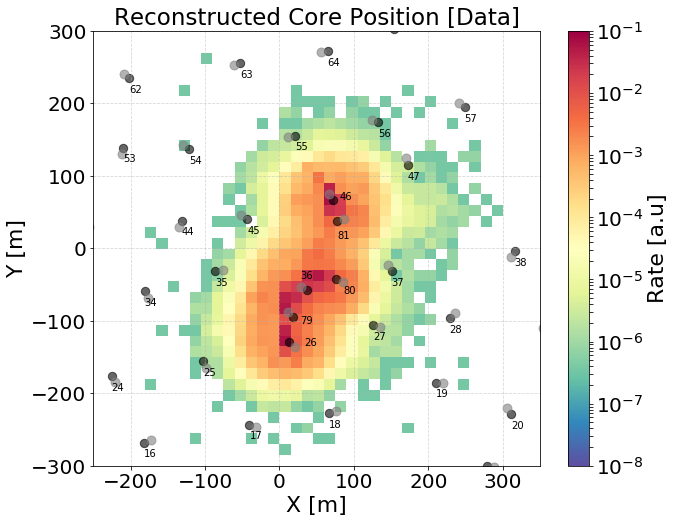

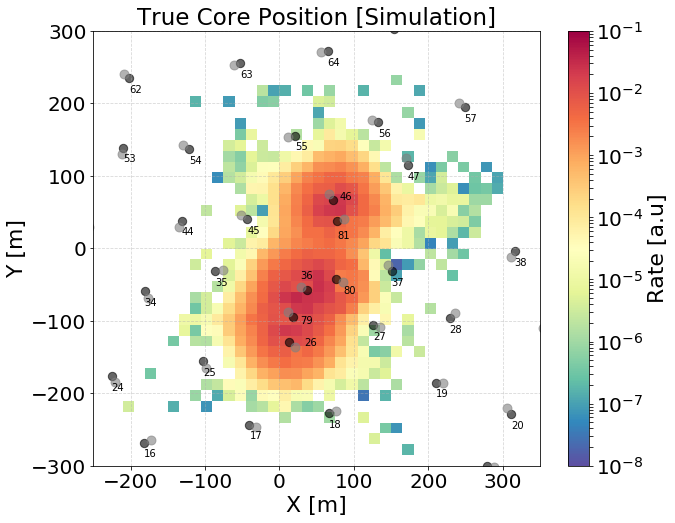

In [35]:
pos_bins = numpy.linspace(-300,300,41)

from tanks_coordinate import all_coordinate

tank_positions = all_coordinate()

XA = numpy.array([tank_positions[station]['A'][0] for station in range(1,82)])
YA = numpy.array([tank_positions[station]['A'][1] for station in range(1,82)]) 
XB = numpy.array([tank_positions[station]['B'][0] for station in range(1,82)])
YB = numpy.array([tank_positions[station]['B'][1] for station in range(1,82)])

pos_bins = numpy.linspace(-300,300,41)

# -------------Plot True Core Position---------------
plt.figure(figsize=(10,8))
plt.scatter(XA, YA, color='k', s=70, alpha=0.6)
plt.scatter(XB, YB, color='gray', s=80, alpha=0.6)
for i in range(81):
    if i+1 in [26]:
        plt.text(XA[i]+20, YA[i]-5, i+1, fontsize=10)
    elif i+1 in [79]:
        plt.text(XA[i]+10, YA[i]-10, i+1, fontsize=10)
    elif i+1 in [46]:
        plt.text(XA[i]+10, YA[i], i+1, fontsize=10)
    elif i+1 in [80]:
        plt.text(XA[i]+10, YA[i]-20, i+1, fontsize=10)
    elif i+1 in [81]:
        plt.text(XA[i], YA[i]-25, i+1, fontsize=10)
    elif i+1 in [36]:
        plt.text(XA[i]-10, YA[i]+15, i+1, fontsize=10)
    elif XA[i]<320. and XA[i]>-250. and abs(YA[i])<300.:
        plt.text(XA[i], YA[i]-20, i+1, fontsize=10)

abc=plt.hist2d(expPredictedX, expPredictedY,
               weights=1./(numpy.ones(len(expPredictedX))*duration),
               bins=[pos_bins,pos_bins], 
               norm=LogNorm(), 
               cmap='Spectral_r', vmin=1e-8, vmax=1e-1)
plt.grid(ls='--', alpha=0.5)
plt.colorbar(label='Rate [a.u]')
plt.xlim(-250,350)
plt.ylim(-300,300)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Reconstructed Core Position [Data]')
if savefig:
    plt.savefig('Plot/core_position_reco_data.png', bbox_inches='tight')

# -------------Plot True Core Position---------------
plt.figure(figsize=(10,8))
plt.scatter(XA, YA, color='k', s=70, alpha=0.6)
plt.scatter(XB, YB, color='gray', s=80, alpha=0.6)
for i in range(81):
    if i+1 in [26]:
        plt.text(XA[i]+20, YA[i]-5, i+1, fontsize=10)
    elif i+1 in [79]:
        plt.text(XA[i]+10, YA[i]-10, i+1, fontsize=10)
    elif i+1 in [46]:
        plt.text(XA[i]+10, YA[i], i+1, fontsize=10)
    elif i+1 in [80]:
        plt.text(XA[i]+10, YA[i]-20, i+1, fontsize=10)
    elif i+1 in [81]:
        plt.text(XA[i], YA[i]-25, i+1, fontsize=10)
    elif i+1 in [36]:
        plt.text(XA[i]-10, YA[i]+15, i+1, fontsize=10)
    elif XA[i]<320. and XA[i]>-250. and abs(YA[i])<300.:
        plt.text(XA[i], YA[i]-20, i+1, fontsize=10)

abc=plt.hist2d(Tcorex, Tcorey,
               weights=Weight0,
               bins=[pos_bins,pos_bins], 
               norm=LogNorm(), 
               cmap='Spectral_r', vmin=1e-8, vmax=1e-1)
plt.grid(ls='--', alpha=0.5)
plt.colorbar(label='Rate [a.u]')
plt.xlim(-250,350)
plt.ylim(-300,300)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('True Core Position [Simulation]')
if savefig:
    plt.savefig('Plot/core_position_true_sim.png', bbox_inches='tight')


In [15]:
if False:
    print len(TankDensity), len(Tenergy), len(Weight0), Tenergy[:2]
    ka= numpy.logspace(4,7.5,36) #Energy
    kha = numpy.linspace(0,3000,101) #TankDensity
    ga=numpy.linspace(0,100,101) #Ntanks
    #midka = 0.5*(ka[:-1]+ka[1:])
    #midkha = 0.5*(kha[:-1]+kha[1:])
    X,Y = numpy.meshgrid(ka,kha)
    H = numpy.histogram2d(Tenergy, TankDensity, bins=[ka,kha], weights=Weight0)[0]
    plt.pcolormesh(X, Y, H.T, norm=LogNorm())
    plt.xscale('log')
    plt.grid()
    #plt.hlines(600,1e4,1e8)
    #plt.vlines(10**5.5,0,3000)
    plt.xlabel('True Primary Energy [GeV]')
    plt.ylabel('Tank Density [#/km2]')
    plt.title("Simulation")
    #plt.savefig(rfr_savedir+'tankdensity_vs_tenergy_simulation_slcQcut.png')

    plt.figure()
    X,Y = numpy.meshgrid(ga,kha)
    H = numpy.histogram2d(Ntanks, TankDensity, bins=[ga,kha], weights=Weight0)[0]
    plt.pcolormesh(X, Y, H.T, norm=LogNorm())
    plt.grid()
    plt.xlabel('Ntanks [GeV]')
    plt.ylabel('Tank Density [#/km2]')
    plt.title("Simulation")
    #plt.savefig(rfr_savedir+'tankdensity_vs_ntanks_simulation_slcQcut.png')

    plt.figure()
    X,Y = numpy.meshgrid(ga,kha)
    H = numpy.histogram2d(expNtanks, expTankDensity, bins=[ga,kha])[0]
    plt.pcolormesh(X, Y, H.T, norm=LogNorm())
    #plt.xscale('log')
    plt.grid()
    #plt.hlines(600,0,50)
    #plt.vlines(10**5.5,0,3000)
    plt.xlabel('Exp Ntanks [GeV]')
    plt.ylabel('Tank Density [#/km2]')
    plt.title("Experiment")
    #plt.savefig(rfr_savedir+'tankdensity_vs_ntanks_experiment_slcQcut.png')


In [16]:
# Data-MC Comparison

q_bins   = numpy.linspace(-3,5,41)  #0.2 bins
zen_bins = numpy.linspace(-5,90,20)  #5deg bins
czbins   = numpy.linspace(-0.01,1,102)
azi_bins = numpy.linspace(0,360,37) #10deg bins
sta_bins = numpy.linspace(0,80,81)
ntanks_bins = numpy.linspace(0,120,121)
#pos_bins    = numpy.linspace(-600,600,41) #30m bins
pos_bins    = numpy.linspace(-600,600,81) #15m bins
tpos_bins   = numpy.linspace(-690,690,24) #60m bins
radius_bins = numpy.linspace(-4,2,31)
tnkden_bins = numpy.linspace(0,2000,101)   #20tanks/sq.km bins
ene_bins    = numpy.linspace(4,7.4,18)
zsc_bins    = numpy.linspace(-5,200,52)
mid_zsc_bins    = 0.5*(zsc_bins[1:] + zsc_bins[:-1]) 
mid_q_bins      = 0.5*(q_bins[1:]+q_bins[:-1])
mid_zen_bins    = 0.5*(zen_bins[1:]+zen_bins[:-1])
mid_czbins      = 0.5*(czbins[:-1]+czbins[1:])
mid_azi_bins    = 0.5*(azi_bins[1:]+azi_bins[:-1])
mid_sta_bins    = 0.5*(sta_bins[1:]+sta_bins[:-1])
mid_ntanks_bins = 0.5*(ntanks_bins[1:]+ntanks_bins[:-1])
mid_pos_bins    = 0.5*(pos_bins[1:]+pos_bins[:-1])
mid_tpos_bins   = 0.5*(tpos_bins[1:]+tpos_bins[:-1])
mid_radius_bins = 0.5*(radius_bins[1:]+radius_bins[:-1])
mid_tnkden_bins = 0.5*(tnkden_bins[1:]+tnkden_bins[:-1])
mid_ene_bins    = 0.5*(ene_bins[1:]+ene_bins[:-1])

Pzenith[numpy.where(numpy.isnan(Pzenith))] = 1.9*numpy.pi
expZenith[numpy.where(numpy.isnan(expZenith))] = 1.9*numpy.pi

expPulsesFlat = expPulses.flatten()
maskexpPulses = expPulsesFlat>=0.1
PulsesFlat    = Pulses.flatten()
maskPulses    = PulsesFlat>=0.1

if do_1d or do_2d:
    mcvariable_dict = {
                    'tankx'  : TankX.flatten(),
                    'tanky'  : TankY.flatten(),
                    'cogx'   : COGX,
                    'cogy'   : COGY,
                    'planezen': numpy.rad2deg(PlaneZenith),
                    'planeazi': numpy.rad2deg(PlaneAzimuth),
                    'zenith' : numpy.rad2deg(Pzenith),
                    'czenith': numpy.cos(Pzenith),
                    'x'      : Pcorex,
                    'y'      : Pcorey,
                    'radius' : numpy.log10(fracRadius.flatten()),
                    'pulse'  : numpy.log10(PulsesFlat[maskPulses]),
                    'nsta'   : Nsta,
                    #'tankdensity': TankDensity,
                    'qsum2'  : numpy.log10(Qsum2),
                    'qtotalhlc': numpy.log10(Qtotalhlc),
                    'energy'   : logPenergy,
                    #'zsc'      : ZSC_avg
                    }
    expvariable_dict = {
                    'tankx'  : expTankX.flatten(),
                    'tanky'  : expTankY.flatten(),
                    'cogx'   : expCOGX,
                    'cogy'   : expCOGY,
                    'planezen': numpy.rad2deg(expPlaneZenith),
                    'planeazi': numpy.rad2deg(expPlaneAzimuth),
                    'zenith' : numpy.rad2deg(expZenith),
                    'czenith': numpy.cos(expZenith),
                    'x'      : expPredictedX,
                    'y'      : expPredictedY,
                    'radius' : numpy.log10(expfracRadius.flatten()),
                    'pulse'  : numpy.log10(expPulsesFlat[maskexpPulses]),
                    'nsta'   : expNsta,
                    #'tankdensity': expTankDensity,
                    'qsum2'  : numpy.log10(expQsum2),
                    'qtotalhlc': numpy.log10(expQtotalhlc),
                    'energy'   : explogPenergy,
                    #'zsc'      : expZSC_avg
                    }
    bin_dict      = {
                    'tankx'  : [tpos_bins, mid_tpos_bins],
                    'tanky'  : [tpos_bins, mid_tpos_bins],
                    'cogx'   : [pos_bins, mid_pos_bins],
                    'cogy'   : [pos_bins, mid_pos_bins],
                    'zenith' : [zen_bins, mid_zen_bins],
                    'planezen': [zen_bins, mid_zen_bins],
                    'planeazi': [azi_bins, mid_azi_bins],
                    'czenith': [czbins, mid_czbins],
                    'x'      : [pos_bins, mid_pos_bins],
                    'y'      : [pos_bins, mid_pos_bins],
                    'radius' : [radius_bins, mid_radius_bins],
                    'pulse'  : [q_bins, mid_q_bins],
                    'nsta'   : [ntanks_bins, mid_ntanks_bins],
                    'tankdensity': [tnkden_bins, mid_tnkden_bins],
                    'qsum2'  : [q_bins, mid_q_bins],
                    'qtotalhlc': [q_bins, mid_q_bins],
                    'energy'   : [ene_bins, mid_ene_bins],
                    'zsc'      : [zsc_bins, mid_zsc_bins]
                    }

    
    xlim_dict     = {
                    'tankx'  : (-700,700),
                    'tanky'  : (-700,700),
                    'cogx'   : (-300,400),
                    'cogy'   : (-350,300),
                    'zenith' : (0,30),
                    'planezen': (0,30),
                    'planeazi': (0,360),
                    'czenith': (0.85, 1),
                    'x'      : (-300,400),
                    'y'      : (-300,300),
                    'radius' : (-4,2),
                    'pulse'  : (-1.5,4),
                    'nsta'   : (0,45),
                    'tankdensity': (0,500),
                    'qsum2'  : (-1,4),
                    'qtotalhlc'  : (-1,4),
                    'energy'   : (4,7.4),
                    'zsc'      : (0,120)
                    }
    ylim_ax1_dict = {
                    'tankx' : (1e-8,10),
                    'tanky'   : (1e-8,10),
                    'cogx': (1e-8,1),
                    'cogy' : (1e-8,1),
                    'zenith' : (1e-3,1),
                    'planezen': (1e-3,1),
                    'planeazi': (1e-2,1e-1),
                    'czenith': (1e-7,1),
                    'x'      : (1e-7,1),
                    'y'      : (1e-7,1),
                    'radius' : (1e-7,1),
                    'pulse'  : (1e-8,1),
                    'nsta'   : (1e-7,1),
                    'tankdensity': (1e-7,1),
                    'qsum2'  : (1e-7,1),
                    'qtotalhlc'  : (1e-6,1),
                    'energy'   : (1e-5,1),
                    'zsc'      : (1e-7,1)
                    }
    ylim_ax2_dict = {
                    'tankx' : (0,2),
                    'tanky'   : (0,2),
                    'cogx': (0,2),
                    'cogy' : (0,2),
                    'zenith' : (0.8,1.2),
                    'planezen': (0.8,1.2),
                    'planeazi': (0.8,1.2),
                    'czenith': (0.8,1.2),
                    'x'      : (0.8,1.2),
                    'y'      : (0.8,1.2),
                    'radius' : (0.8,2),
                    'pulse'  : (0.8,1.2),
                    'nsta'   : (0.8,2),
                    'tankdensity': (0.8,1.2),
                    'qsum2'  : (0.8,1.2),
                    'qtotalhlc'  : (0.8,2),
                    'energy'   : (0.8,1.2),
                    'zsc'      : (0.8,1.2)
                    }

    label_dict    = {
                    'tankx'  : r'X$_{\rm tank}$ [m]',
                    'tanky'  : r'Y$_{\rm tank}$ [m]',
                    'cogx'   : r'X$_{\rm COG}$ [m]',
                    'cogy'   : r'Y$_{\rm COG}$ [m]',
                    'zenith' : r'$\theta{\rm reco}$ [deg]',
                    'planezen': r'$\theta{\rm plane}$ [deg]',
                    'planeazi': r'$\phi{\rm plane}$ [deg]',
                    'czenith': r'cos$\theta{\rm reco}$',
                    'x'      : r'X$_{\rm reco}$ [m]',
                    'y'      : r'Y$_{\rm reco}$ [m]',
                    'radius' : r'log[R$_{\rm tank}$]',
                    'pulse'  : r'log[Q$_{\rm tank}$/VEM]',
                    'nsta'   : r'N$_{\rm station}$',
                    'tankdensity': r'Tank Density [N/km$^2$]',
                    'qsum2'  : r'log[Q$_{\rm sum2}$/VEM]',
                    'qtotalhlc': r'log[Q$_{\rm total}$/VEM]',
                    'energy'   : r'log[E$_{\rm reco}$/GeV]',
                    'zsc'      : 'ZSC$_{\rm avg}$ [m]'
                    }

1D Plots
tankx :
3514420 3514420


/Users/rameshkoirala/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: invalid value encountered in divide
/Users/rameshkoirala/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in divide


['666.84%', '122.81%', '32.83%', '55.04%', '27.54%', '31.63%', '12.74%', '11.82%', '9.33%', '-0.16%', '-0.65%', '7.90%', '2.98%', '12.48%', '27.26%', '51.07%', '42.14%', '151.67%', '97.63%', '325.25%']
Rate [MC, Data]: [ 40.63678791488356 , 2.9301649646636334e-05 ]
tanky :
3514420 3514420
['47.44%', '47.34%', '16.67%', '47.79%', '7.81%', '9.71%', '3.43%', '0.13%', '-0.24%', '-0.13%', '-0.50%', '10.86%', '18.80%', '32.85%', '47.60%', '35.00%', '88.71%', 'nan%', 'nan%', 'nan%']
Rate [MC, Data]: [ 40.63678791488343 , 2.930164964663634e-05 ]
nsta :
100412 100412
['-1.60%', '0.78%', '1.94%', '4.04%', '3.93%', '7.41%', '5.86%', '5.62%', '7.69%', '13.23%', '13.58%', '18.76%', '19.07%', '10.44%', '21.39%', '14.49%', '19.38%', '6.71%', '20.99%', '4.48%']
Rate [MC, Data]: [ 1.161051083282393 , 8.37189989903896e-07 ]
planeazi :
100412 100412
['-11.39%', '15.51%', '2.19%', '2.35%', '16.18%', '8.45%', '5.86%', '4.52%', '1.65%', '1.53%', '3.63%', '-4.10%', '-5.90%', '5.15%', '-11.47%', '-3.33%', '0.

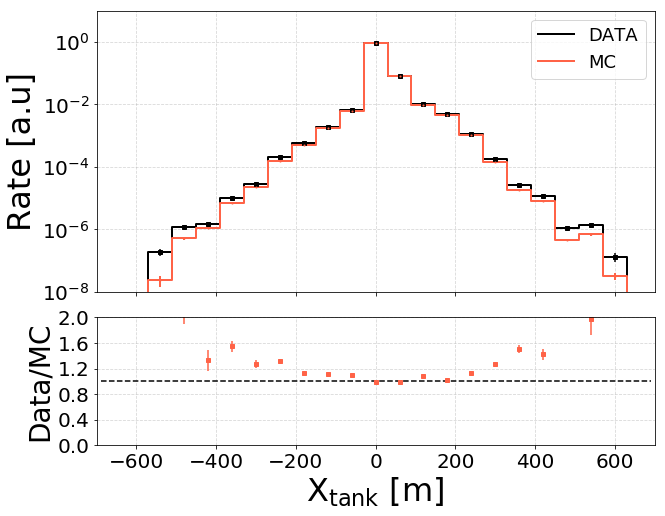

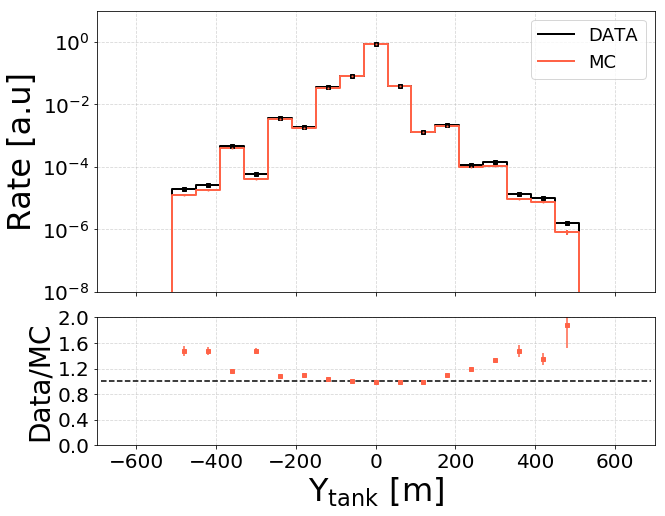

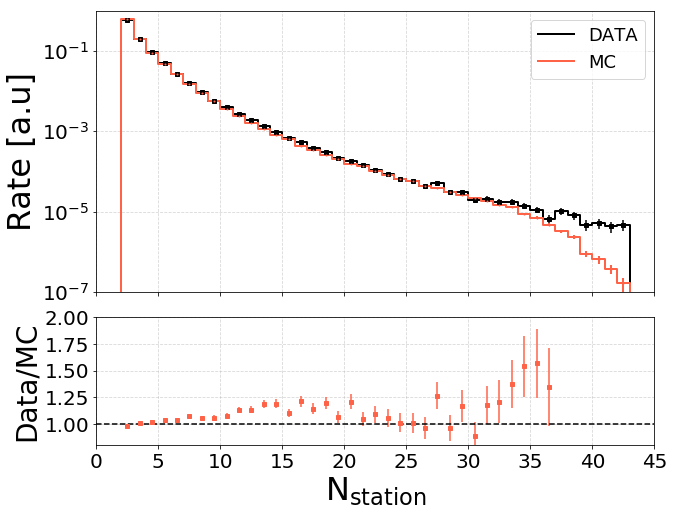

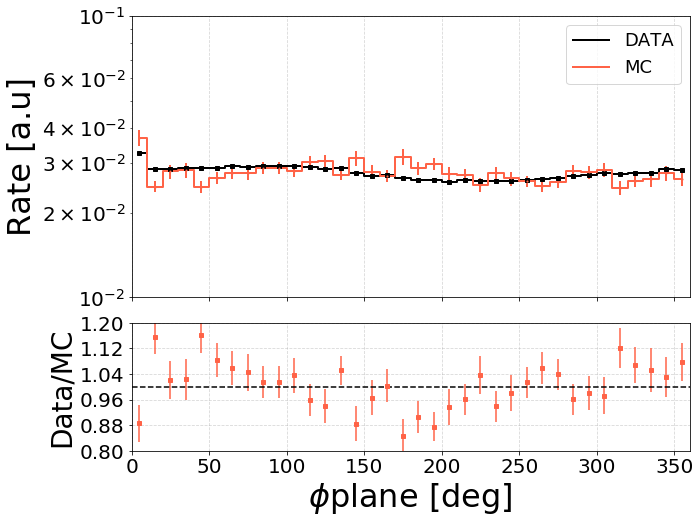

In [20]:
# 1D
do_list         = ['nsta', 'qtotalhlc', 'x', 'y', 'cogx', 'cogy', 'zenith', 'energy', #'zsc',
                   'planezen', 'planeazi', 'tankx', 'tanky', 'radius', 'pulse']
#do_list         = ['nsta', 'qtotalhlc', 'x', 'y', 'cogx', 'cogy', 'zenith', 'energy', #'zsc',
#                   'planezen', 'planeazi']
do_list         = ['tankx', 'tanky', 'nsta','planeazi']
color           = 'tomato'
    
print '1D Plots'
if do_1d:
    do_list1d  = do_list

    for key in do_list1d:
        print "================================================================="
        print key, ":"
        bins        = bin_dict[key][0]
        mid_bins    = bin_dict[key][1]
        xlims       = xlim_dict[key]
        ylims_ax1   = ylim_ax1_dict[key]
        ylims_ax2   = ylim_ax2_dict[key]
        label       = label_dict[key]
        ylabel      = 'Rate [a.u]' #'Normalized'
        mcvar       = mcvariable_dict[key]
        expvar      = expvariable_dict[key]
        mcvar       = numpy.nan_to_num(mcvar)
        expvar      = numpy.nan_to_num(expvar)

        if (key=='pulse'):
            Weight2d=numpy.asarray([35*[wt] for wt in Weight0])
            Weight=(Weight2d.flatten())[maskPulses]
        elif (key=='radius') or (key=='tankx') or (key=='tanky'):
            Weight2d=numpy.asarray([35*[wt] for wt in Weight0])
            Weight=Weight2d.flatten()
        else:
            Weight=Weight0
            
        print len(mcvar), len(Weight)

        expweight   = numpy.array(len(expvar)*[1./duration[0]])
        y           = numpy.histogram(mcvar, bins=bins, weights=Weight)[0]
        expy        = numpy.histogram(expvar, bins=bins, weights=expweight)[0]
        errMC       = numpy.sqrt(numpy.histogram(mcvar, bins=bins, weights=Weight**2)[0])
        errData     = numpy.sqrt(numpy.histogram(expvar, bins=bins, weights=expweight**2)[0])
        
        # Normalized rate for Data and MC.
        #y          = numpy.histogram(mcvar, bins=bins, weights=Weight, normed=True)[0]
        #expy       = numpy.histogram(expvar, bins=bins, weights=expweight, normed=True)[0]
        #DatabyMC   = (numpy.sum(y)/numpy.sum(expy))*expy/y 

        ynorm       = y/numpy.sum(y)
        expynorm    = expy/numpy.sum(expy)
        errMCnorm   = errMC/numpy.sum(y)
        errDatanorm = errData/numpy.sum(expy)
        errDatabyMC = errorXbyY(expynorm, ynorm, errDatanorm, errMCnorm)
        DatabyMC    = expynorm/ynorm
        
        #print [r"%.2f%%"%(100*ka-100) for ka in DatabyMC if (ka>=0) and ka<2][:18]
        non_nan_indx = numpy.where(~numpy.isnan(DatabyMC))[0][0]
        print [r"%.2f%%"%(100*ka-100) for ka in DatabyMC][non_nan_indx:non_nan_indx+20]

        plt.figure(figsize=(10,8))
        gs = gridspec.GridSpec(3, 2)
        ax1 = plt.subplot(gs[:2, :])
        ax2 = plt.subplot(gs[2, :], sharex=ax1)

        ax1.step(mid_bins, expynorm, color='k', label='DATA', linewidth=2, where='mid')
        ax1.step(mid_bins, ynorm, color=color, label='MC', linewidth=2, where='mid')
        ax1.errorbar(mid_bins, expynorm, color='k', linewidth=1.5,
                    yerr=errDatanorm, ls='', marker='s', markersize=4.5)
        ax1.errorbar(mid_bins, ynorm, color='tomato', linestyle='', linewidth=2,
                    yerr=errMCnorm, ls='', marker='s', markersize=1)
        ax2.errorbar(mid_bins, DatabyMC, yerr=errDatabyMC, 
                     color=color, label='Data/%s'%composition_model.upper(), ls='', 
                     marker='s', markersize=4)
        ax2.hlines(1, min(bins), max(bins), linestyles='--', linewidth=1.5)
        if key!='czenith':
            ax1.set_yscale('log')
        else:
            pass
            #ax1.set_ylim(0,0.3)
        if key=='tankdensity':
            ax2.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
        ax1.legend(loc='best', frameon=True)
        ax1.set_ylabel(ylabel, fontsize=32)
        ax1.set_xlim(xlims)
        ax1.tick_params(labelbottom='off')
        ax1.set_ylim(ylims_ax1)
        ax1.grid(linestyle='--', alpha=0.5)
        ax2.set_ylim(ylims_ax2)
        #ax2.set_ylim(-5,5)
        ax2.yaxis.set_major_locator(plt.MaxNLocator(5))
        ax2.set_xlabel(label, fontsize=32)
        ax2.set_ylabel('Data/MC', fontsize=28)
        ax2.grid(linestyle='--', alpha=0.5)
        #if savefig:
        if True:
            plt.savefig(rfr_savedir+'data_mc_comparison_'+key+'_'+composition_model+name+'.png', bbox_inches='tight')
        if False:
            hf = tables.open_file(rfr_savedir+'data_mc_comparison.h5', 'a')
            mcname     = 'mc_'+key+'_'+composition_model
            errmcname  = 'mcerr_'+key+'_'+composition_model
            expname    = 'exp_'+key+'_'+composition_model
            errexpname = 'experr_'+key+'_'+composition_model
            errexpbymc = 'errexpbymc_'+key+'_'+composition_model
            binname    = key+'_bin'
            midbinname = key+'_midbin'
            if mcname in hf.root:
                hf.remove_node('/', mcname)
                hf.remove_node('/', errmcname)
            if expname in hf.root:
                hf.remove_node('/', expname)
                hf.remove_node('/', errexpname)
                hf.remove_node('/', errexpbymc)
            if binname in hf.root:
                hf.remove_node('/', binname)
                hf.remove_node('/', midbinname)
            hf.create_array('/', mcname, y)
            hf.create_array('/', expname, expy/duration)
            hf.create_array('/', errmcname, errMC)
            hf.create_array('/', errexpname, errData)
            hf.create_array('/', errexpbymc, errDatabyMC)
            hf.create_array('/', binname, bins)
            hf.create_array('/', midbinname, mid_bins)
            hf.close()

        print 'Rate [MC, Data]: [', sum(y), ',', sum(expy/duration), ']'

In [ ]:
for key in ['pulse']:
    print "================================================================="
    print key, ":"
    bins        = bin_dict[key][0]
    mid_bins    = bin_dict[key][1]
    xlims       = xlim_dict[key]
    ylims_ax2   = ylim_ax2_dict[key]
    label       = label_dict[key]
    ylabel      = 'Rate [a.u]' #'Normalized'
    mcvar       = mcvariable_dict[key]
    expvar      = expvariable_dict[key]
    mcvar       = numpy.nan_to_num(mcvar)
    expvar      = numpy.nan_to_num(expvar)

    if (key=='pulse'):
        Weight2d=numpy.asarray([35*[wt] for wt in Weight0])
        Weight=(Weight2d.flatten())[maskPulses]
    elif (key=='radius') or (key=='tankx') or (key=='tanky'):
        Weight2d=numpy.asarray([35*[wt] for wt in Weight0])
        Weight=Weight2d.flatten()
    else:
        Weight=Weight0

    expweight   = numpy.array(len(expvar)*[1./duration[0]])
    y           = numpy.histogram(mcvar, bins=bins, weights=Weight)[0]
    expy        = numpy.histogram(expvar, bins=bins, weights=expweight)[0]
    errMC       = numpy.sqrt(numpy.histogram(mcvar, bins=bins, weights=Weight**2)[0])
    errData     = numpy.sqrt(numpy.histogram(expvar, bins=bins, weights=expweight**2)[0])
    errDatabyMC = errorXbyY(expy/numpy.sum(expy), y/numpy.sum(y), errData, errMC)
    # Normalized rate for Data and MC.
    #y           = numpy.histogram(mcvar, bins=bins, weights=Weight, normed=True)[0]
    #expy        = numpy.histogram(expvar, bins=bins, weights=expweight, normed=True)[0]
    DatabyMC    = (numpy.sum(y)/numpy.sum(expy))*expy/y

    #print [r"%.2f%%"%(100*ka-100) for ka in DatabyMC if (ka>=0) and ka<2][:18]
    non_nan_indx = numpy.where(~numpy.isnan(DatabyMC))[0][0]
    print [r"%.2f%%"%(100*ka-100) for ka in DatabyMC][non_nan_indx:non_nan_indx+20]

    plt.figure()
    gs = gridspec.GridSpec(3, 2)
    ax1 = plt.subplot(gs[:2, :])
    ax2 = plt.subplot(gs[2, :], sharex=ax1)

    ax1.step(mid_bins, expy/numpy.sum(expy), color='k', label='DATA', linewidth=2, where='mid')
    ax1.step(mid_bins, y/numpy.sum(y), color=color, label='MC', linewidth=2, where='mid')
    ax1.errorbar(mid_bins, expy/numpy.sum(expy), color='k', linewidth=1.5,
                yerr=errData, ls='', marker='s', markersize=4.5)
    ax2.errorbar(mid_bins, DatabyMC, yerr=errDatabyMC, 
                 color=color, label='Data/%s'%composition_model.upper(), ls='', 
                 marker='s', markersize=4)
    ax2.hlines(1, min(bins), max(bins), linestyles='--', linewidth=1.5)
    if key!='czenith':
        ax1.set_yscale('log')
        ax1.set_ylim(1e-8,1)
    else:
        pass
        #ax1.set_ylim(0,0.3)
    if key=='tankdensity':
        ax2.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
    ax1.legend(loc='best', frameon=True)
    ax1.set_ylabel(ylabel)
    ax1.set_xlim(-1.5,4)
    ax1.tick_params(labelbottom='off')
    ax2.set_ylim(ylims_ax2)
    #ax2.set_ylim(-5,5)
    ax2.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax2.set_xlabel(label)
    ax2.set_ylabel('Data/MC')



In [ ]:
print numpy.max(mcvariable_dict['radius'])
plt.figure()
abc = plt.hist2d(Pcorex, Pcorey, weights=Weight0, bins=[50,50], norm=LogNorm(), cmap='Spectral_r', vmin=1e-8, vmax=1e-1)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Core Position after Quality Cuts [Reco]', fontsize=18)
plt.colorbar(label='a.u')
plt.xlim(-200,300)
plt.ylim(-300,300)
if True:
    plt.savefig(rfr_savedir+'position_scatter_reco_xy.png', bbox_inches='tight')

plt.figure()
abc = plt.hist2d(expPredictedX, expPredictedY, weights=len(expPredictedX)*[1./duration[0]], bins=[50,50], norm=LogNorm())


In [ ]:
# 2D
print '2D Plots'
if do_2d:
    import matplotlib
    import matplotlib.backends.backend_pdf
    
    savepdf  = '/Users/ramesh/GoogleDrive/LowEnergy/mc_variables_2d.pdf'
    pdf      = matplotlib.backends.backend_pdf.PdfPages(savepdf)
    
    done_list       = []
    dont_list       = ['pulse', 'radius', 'tankx', 'tanky']
    counter = 0
    for key1 in do_list:
        for key2 in do_list:
            if (key1!=key2) and (key2 not in done_list) and (key1 not in dont_list) and \
               (key2 not in dont_list):
                done_list.append(key1)
                counter += 1
                #if key1=='radius':
                #    key2='pulse'
                #    done_list.append(key2)
                print "================================================================="
                print counter, 'Plotting Data and MC: ',key1, key2
                bins1        = bin_dict[key1][0]
                mid_bins1    = bin_dict[key1][1]
                xlims1       = xlim_dict[key1]
                label1       = label_dict[key1]
                mcvar1       = mcvariable_dict[key1]
                expvar1      = expvariable_dict[key1]
                #------------
                bins2        = bin_dict[key2][0]
                mid_bins2    = bin_dict[key2][1]
                xlims2       = xlim_dict[key2]
                label2       = label_dict[key2]
                mcvar2       = mcvariable_dict[key2]
                expvar2      = expvariable_dict[key2]

                if (key1=='pulse') or (key1=='radius'):
                    Weight2d=numpy.asarray([35*[wt] for wt in Weight0])
                    Weight=Weight2d.flatten()
                else:
                    Weight=Weight0

                fig = plt.figure(figsize=(12, 7))
                gs = gridspec.GridSpec(2, 2)
                ax1 = plt.subplot(gs[:, 0])
                ax2 = plt.subplot(gs[:, 1], sharex=ax1)
                #ax3 = plt.subplot(gs[:, 2], sharex=ax1)

                abcexp = ax1.hist2d(expvar1, expvar2, bins=[bins1, bins2], 
                                    weights=len(expvar1)*[1./duration[0]],
                                    norm=LogNorm(), vmin=1e-8, vmax=1e-1)
                abcmc  = ax2.hist2d(mcvar1, mcvar2, bins=[bins1, bins2], weights=Weight,
                                    norm=LogNorm(), vmin=1e-8, vmax=1e-1
                                   )
                X,Y = numpy.meshgrid(bins1, bins2)
                pcm = ax3.pcolormesh(X, Y, numpy.absolute(abcexp[0]-abcmc[0]).T, 
                               norm=LogNorm(), vmin=1e-8, vmax=1e-1)

                ax1.set_xlabel(label1)
                ax1.set_ylabel(label2)
                ax1.set_xlim(xlims1)
                ax1.set_ylim(xlims2)
                ax1.set_title('Data')
                ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
                ax2.set_xlabel(label1)
                #ax2.set_ylabel(label2)
                ax2.set_xlim(xlims1)
                ax2.set_ylim(xlims2)
                ax2.set_title('MC')
                ax2.set_yticklabels([])
                #ax2.yaxis.set_label_position("right")
                #ax2.yaxis.tick_right()
                #ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
                '''ax3.set_xlim(xlims1)
                ax3.set_ylim(xlims2)
                ax3.set_xlabel(label1)'''
                #ax3.set_ylabel(label2)
                #ax3.yaxis.set_label_position("right")
                '''ax3.set_yticklabels([])'''
                #ax3.yaxis.tick_right()
                '''ax3.grid()'''
                #ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
                '''ax3.set_title('|Data-MC|')'''
                fig.colorbar(pcm)
                pdf.savefig(fig)
                if savefig:
                    plt.savefig(rfr_savedir+'data_mc_comparison_2d_'+key+'_'+composition_model+name+'.png')
                plt.close()
    pdf.close()


In [ ]:
mctime  = HitsTime.flatten()
#exptime2d = numpy.array([numpy.diff(numpy.array(sorted(ar))) for ar in expHitsTime])
exptime = expHitsTime.flatten()
Weight2d=numpy.asarray([35*[wt] for wt in Weight0])
Weight=Weight2d.flatten()

In [ ]:
#deltaT_bins = numpy.linspace(1e-8,500,101)
#if 'radius' in do_list:
if True:
    #deltaT_bins = numpy.logspace(-5,7,51)
    deltaT_bins = numpy.linspace(1e-4,1000,51)
    middeltaT_bins = 0.5*(deltaT_bins[1:] + deltaT_bins[:-1])

    expweight   = numpy.array(len(exptime[exptime>0])*[1./duration[0]])

    mcweight    = Weight[mctime>0]
    mcT         = mctime[mctime>0]
    expT        = exptime[exptime>0]
    y           = numpy.histogram(mcT, bins=deltaT_bins, weights=mcweight)[0]
    expy        = numpy.histogram(expT, bins=deltaT_bins, weights=expweight)[0]
    errMC       = numpy.sqrt(numpy.histogram(mcT, bins=deltaT_bins, weights=mcweight**2)[0])
    errData     = numpy.sqrt(numpy.histogram(expT, bins=deltaT_bins, weights=expweight**2)[0])
    errDatabyMC = errorXbyY(expy/numpy.sum(expy), y/numpy.sum(y), errData, errMC)
    # Normalized rate for Data and MC.
    DatabyMC    = (numpy.sum(y)/numpy.sum(expy))*expy/y

    non_nan_indx = numpy.where(~numpy.isnan(DatabyMC))[0][0]
    print [r"%.2f%%"%(100*ka-100) for ka in DatabyMC][non_nan_indx:non_nan_indx+20]

    plt.figure()
    gs = gridspec.GridSpec(3, 2)
    ax1 = plt.subplot(gs[:2, :])
    ax2 = plt.subplot(gs[2, :], sharex=ax1)

    ax1.step(middeltaT_bins, expy/numpy.sum(expy), color='k', label='DATA', linewidth=2, where='mid')
    ax1.step(middeltaT_bins, y/numpy.sum(y), color=color, label='MC', linewidth=2, where='mid')
    ax1.errorbar(middeltaT_bins, expy/numpy.sum(expy), color='k', linewidth=1.5,
                yerr=errData, ls='', marker='s', markersize=4.5)
    ax2.errorbar(middeltaT_bins, DatabyMC, yerr=errDatabyMC, 
                 color=color, label='Data/%s'%composition_model.upper(), ls='', 
                 marker='s', markersize=4)
    ax2.hlines(1, min(deltaT_bins), max(deltaT_bins), linestyles='--', linewidth=1.5)
    if key!='czenith':
        ax1.set_yscale('log')
        #ax1.set_ylim(1e-7,10)
    else:
        pass
        #ax1.set_ylim(0,0.3)
    if key=='tankdensity':
        ax2.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
    ax1.legend(loc='best', frameon=True)
    ax1.grid(ls='--', alpha=0.5)
    ax1.set_ylabel(ylabel)
    ax1.tick_params(labelbottom='off')
    ax2.set_xlim(0,1e3)
    #ax2.set_ylim(ylims_ax2)
    ax2.set_ylim(0.8,1.2)
    ax2.grid(ls='--', alpha=0.5)
    ax2.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax2.set_xlabel(r'T$_{\rm tank}$ [ns]')
    ax2.set_ylabel('Data/MC')
    if savefig:
        plt.savefig(rfr_savedir+'data_mc_comparison_time_difference_'+composition_model+name+'.png')
        
if 'radius' in do_list:
    
    #deltaT_bins = numpy.logspace(-5,7,51)
    avgZsc_bins = numpy.linspace(0,100,51)
    avgZsc_bins = 0.5*(avgZsc_bins[1:] + avgZsc_bins[:-1])

    expweight   = numpy.array(len(expNsta)*[1./duration[0]])
    mcweight    = Weight[mctime>0]
    mcT         = mctime[mctime>0]
    expT        = exptime[exptime>0]
    y           = numpy.histogram(mcT, bins=deltaT_bins, weights=mcweight)[0]
    expy        = numpy.histogram(expT, bins=deltaT_bins, weights=expweight)[0]
    errMC       = numpy.sqrt(numpy.histogram(mcT, bins=deltaT_bins, weights=mcweight**2)[0])
    errData     = numpy.sqrt(numpy.histogram(expT, bins=deltaT_bins, weights=expweight**2)[0])
    errDatabyMC = errorXbyY(expy/numpy.sum(expy), y/numpy.sum(y), errData, errMC)
    # Normalized rate for Data and MC.
    #y           = numpy.histogram(mcvar, bins=bins, weights=Weight, normed=True)[0]
    #expy        = numpy.histogram(expvar, bins=bins, weights=expweight, normed=True)[0]
    DatabyMC    = (numpy.sum(y)/numpy.sum(expy))*expy/y

    #print [r"%.2f%%"%(100*ka-100) for ka in DatabyMC if (ka>=0) and ka<2][:18]
    non_nan_indx = numpy.where(~numpy.isnan(DatabyMC))[0][0]
    print [r"%.2f%%"%(100*ka-100) for ka in DatabyMC][non_nan_indx:non_nan_indx+20]

    plt.figure()
    gs = gridspec.GridSpec(3, 2)
    ax1 = plt.subplot(gs[:2, :])
    ax2 = plt.subplot(gs[2, :], sharex=ax1)

    ax1.step(middeltaT_bins, expy/numpy.sum(expy), color='k', label='DATA', linewidth=2, where='mid')
    ax1.step(middeltaT_bins, y/numpy.sum(y), color=color, label='MC', linewidth=2, where='mid')
    ax1.errorbar(middeltaT_bins, expy/numpy.sum(expy), color='k', linewidth=1.5,
                yerr=errData, ls='', marker='s', markersize=4.5)
    ax2.errorbar(middeltaT_bins, DatabyMC, yerr=errDatabyMC, 
                 color=color, label='Data/%s'%composition_model.upper(), ls='', 
                 marker='s', markersize=4)
    ax2.hlines(1, min(deltaT_bins), max(deltaT_bins), linestyles='--', linewidth=1.5)
    if key!='czenith':
        ax1.set_yscale('log')
        #ax1.set_ylim(1e-7,10)
    else:
        pass
        #ax1.set_ylim(0,0.3)
    if key=='tankdensity':
        ax2.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
    ax1.legend(loc='best', frameon=True)
    #ax1.set_xscale('log')
    ax1.set_ylabel(ylabel)
    #ax1.set_xlim(xlims)
    ax1.tick_params(labelbottom='off')
    #ax2.set_ylim(ylims_ax2)
    ax2.set_ylim(0.8,1.2)
    ax2.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax2.set_xlabel('hitT [ns]')
    ax2.set_ylabel('Data/MC')
    if savefig:
        plt.savefig(rfr_savedir+'time_difference_hlc_hit_SRTCleaned_'+composition_model+name+'.png')

In [ ]:
# Snow Height on top of 6 stations
# rkoirala@cobalt07 /data/user/rkoirala/LowEnergyNew $ python snowheight_sta2.py
# Snow height from May 2106 to April 2017 (12790-129450, all runs. not just ending at "0".
snow_height_file = numpy.load('/Users/ramesh/GoogleDrive/LowEnergy/NoteBook/snow_height_avg.npy')
snow_height_dict_data = snow_height_file.item()
snow_height_dict_mc = {1: [1.297], 2: [0.923], 3: [1.183], 4: [1.05], 5: [0.651], 6: [1.025], 7: [1.349], 8: [1.553], 9: [0.867], 10: [0.887], 11: [0.948], 12: [0.503], 13: [1.707], 14: [1.446], 15: [1.558], 16: [1.54], 17: [1.377], 18: [0.909], 19: [0.891], 20: [1.081], 21: [2.714], 22: [1.641], 23: [1.512], 24: [1.568], 25: [2.255], 26: [2.663], 27: [1.366], 28: [1.701], 29: [3.244], 30: [2.294], 31: [1.663], 32: [1.554], 33: [1.569], 34: [1.288], 35: [1.548], 36: [1.549], 37: [0.496], 38: [2.404], 39: [2.819], 40: [2.324], 41: [1.655], 42: [1.521], 43: [1.683], 44: [1.927], 45: [2.207], 46: [2.72], 47: [2.528], 48: [2.447], 49: [2.295], 50: [2.123], 51: [1.608], 52: [1.73], 53: [1.774], 54: [2.328], 55: [2.292], 56: [2.673], 57: [3.75], 58: [2.338], 59: [2.397], 60: [1.819], 61: [1.638], 62: [1.741], 63: [1.998], 64: [2.306], 65: [2.23], 66: [2.565], 67: [2.163], 68: [1.791], 69: [1.563], 70: [1.739], 71: [2.186], 72: [1.778], 73: [1.899], 74: [2.01], 75: [1.595], 76: [1.72], 77: [1.982], 78: [1.671], 79: [1.634], 80: [0.69], 81: [1.32]}

N = 81

MCMeans = numpy.array([numpy.mean(snow_height_dict_mc[i]) for i in range(1,82)])
DataMeans = numpy.array([numpy.mean(snow_height_dict_data[i]) for i in range(1,82)])
             
ind    = numpy.arange(1,N+1)    # the x locations for the groups
width  = 0.25       # the width of the bars: can also be len(x) sequence
expcol = 'k'
mccol  = 'tomato'

plt.figure()
p1 = plt.bar(ind-width/1.5, MCMeans, width, color=mccol, edgecolor=mccol)
p2 = plt.bar(ind+width/1.5, DataMeans, width, color=expcol, edgecolor=expcol)

plt.ylabel('Snow Height [m]')
plt.title('MC: Oct 2016, Data: Avg May16-Apr17')
#plt.xticks(ind+0.15, ('26', '36', '46', '79', '80', '81'))
plt.yticks(numpy.arange(0, 4, 0.3))
plt.legend((p1[0], p2[0]), ('MC', 'DATA'))
plt.xlabel('Station Number')
plt.xlim(0,82)
plt.text(2,3.7, r'Total Snow', fontsize=17)
plt.text(2,3.5, r'MC  : %.2f m'%numpy.sum(MCMeans), fontsize=14, color=mccol)
plt.text(2,3.3, r'Data: %.2f m'%numpy.sum(DataMeans), fontsize=14, color=expcol)
plt.grid(lw=0.3)
if savefig:
    plt.savefig(rfr_savedir+'snow_height_data_mc_comparison_allStation.png')

plt.figure()
p1 = plt.bar(ind-width/1.5, MCMeans-DataMeans, width, color='k', edgecolor='k')
#p2 = plt.bar(ind+width/1.5, DataMeans, width, color='g', edgecolor='g')

plt.ylabel('Difference [m]')
plt.title('Snow Height Difference [MC-Data]')
#plt.xticks(ind+0.15, ('26', '36', '46', '79', '80', '81'))
plt.yticks(numpy.linspace(-0.2, 0.4, 7))
#plt.legend((p1[0], p2[0]), ('MC', 'DATA'))
plt.xlabel('Station Number')
plt.xlim(0,82)
plt.text(25,0.22, r'26', fontsize=14)
plt.text(35,0.26, r'36', fontsize=14)
#plt.text(2,3.3, r'Data: %.2f m'%numpy.sum(DataMeans), fontsize=14, color='g')
plt.grid(lw=0.3)
if savefig:
    plt.savefig(rfr_savedir+'snow_height_data_mc_difference_allStation.png')
    
    
# Snow height and Station rate
N = 6
MCMeans = numpy.array([numpy.mean(snow_height_dict_mc[i]) for i in [26,36,46,79,80,81]])
DataMeans = numpy.array([numpy.mean(snow_height_dict_data[i]) for i in [26,36,46,79,80,81]])
             
ind    = numpy.arange(1,N+1)    # the x locations for the groups
width  = 0.25       # the width of the bars: can also be len(x) sequence
plt.figure()
p1 = plt.bar(ind-width/2., MCMeans, width, color=mccol, edgecolor=mccol)
p2 = plt.bar(ind+width/2., DataMeans, width, color=expcol, edgecolor=expcol)

plt.ylabel('Snow Height [m]')
plt.title('MC: Oct 2016, Data: Avg May16-Apr17')
plt.xticks(ind+0.15, ('26', '36', '46', '79', '80', '81'))
plt.yticks(numpy.arange(0, 4, 0.3))
plt.legend((p1[0], p2[0]), ('MC', 'DATA'))
plt.xlabel('Station Number')
plt.text(0.5,3.6, r'Total Snow', fontsize=17)
plt.text(0.5,3.4, r'MC  : %.2f m'%numpy.sum(MCMeans), fontsize=14, color=mccol)
plt.text(0.5,3.2, r'Data: %.2f m'%numpy.sum(DataMeans), fontsize=14, color=expcol)
plt.grid(lw=0.3)
if savefig:
    plt.savefig(rfr_savedir+'snow_height_data_mc_comparison_STA2_Station.png')



In [ ]:
if False:
    # -------------------------------------------------------------
    # Station rate
    hf = tables.open_file('/Users/ramesh/GoogleDrive/LowEnergy/analysis_simulation_sta2_Ntanks_leq35_ML_seedCOG_all.h5')
    sta26 = hf.root.numStationHit.cols.sta26[:]
    sta36 = hf.root.numStationHit.cols.sta36[:]
    sta46 = hf.root.numStationHit.cols.sta46[:]
    sta79 = hf.root.numStationHit.cols.sta79[:]
    sta80 = hf.root.numStationHit.cols.sta80[:]
    sta81 = hf.root.numStationHit.cols.sta81[:]
    hf.close()

    hf = tables.open_file('/Users/ramesh/GoogleDrive/LowEnergy/analysis_experiment_ML_COG_0.h5')
    expsta26 = hf.root.numStationHit.cols.sta26[:]
    expsta36 = hf.root.numStationHit.cols.sta36[:]
    expsta46 = hf.root.numStationHit.cols.sta46[:]
    expsta79 = hf.root.numStationHit.cols.sta79[:]
    expsta80 = hf.root.numStationHit.cols.sta80[:]
    expsta81 = hf.root.numStationHit.cols.sta81[:]
    hf.close()

    mc_starate = numpy.array([sta26,sta36,sta46,sta79,sta80,sta81])/max(sta80)
    exp_starate= numpy.array([expsta26,expsta36,expsta46,expsta79,expsta80,expsta81])/max(expsta80)

    plt.figure()
    p1 = plt.bar(ind-width/2., mc_starate, width, 
                 color=mccol, edgecolor=mccol)
    p2 = plt.bar(ind+width/2., exp_starate, width, 
                 color=expcol, edgecolor=expcol)

    plt.ylabel('Rate [Hz]')
    plt.title('Station Rate')
    plt.xticks(ind+0.15, ('26', '36', '46', '79', '80', '81'))
    plt.yticks(numpy.arange(0, 1.2, 0.1))
    plt.legend((p1[0], p2[0]), ('MC', 'DATA'))
    #plt.legend((p1[0]), ('MC'))
    plt.xlabel('Station Number')
    plt.text(0.3,1.1, r'Sum of Rate', fontsize=17)
    plt.text(0.3,1.04, r'MC  : %.2f Hz'%numpy.sum(mc_starate), fontsize=14, color=mccol)
    plt.text(0.3,0.98, r'Data: %.2f Hz'%numpy.sum(exp_starate), fontsize=14, color=expcol)
    plt.grid(lw=0.3)
    if savefig:
        plt.savefig(rfr_savedir+'sta2_rate_data_mc_comparison.png')


In [ ]:
if isqgsjet:
    # Compare Nsta, Nslc, Ntanks between Sybill2.1 and QGSJETII-04
    hf = tables.open_file('/Users/ramesh/GoogleDrive/LowEnergy/analysis_simulation_sta2_Ntanks_leq35_qgsjet_all.h5')
    Tenergyq    = hf.root.Energy[:]
    FiltCondtq  = hf.root.FiltCondt[:]
    LoudStaq    = hf.root.LoudSta[:]
    Qhillasq   = hf.root.Qhillas[:]
    Qtotalq    = hf.root.Qtotal[:]
    Qmaxq      = hf.root.Qmax[:]
    Qtotalhlcq = hf.root.Qtotalhlc[:]
    Nstaq      = hf.root.Nsta[:]
    Nslcq      = hf.root.Nslc[:]
    Ntanksq    = hf.root.Ntanks[:]
    Weightq    = hf.root.WeightH4a[:]
    Pzenithq   = hf.root.Plane_Zenith[:]
    PredictedXq= hf.root.COGX[:]
    PredictedYq= hf.root.COGY[:]
    Pulsesq     = numpy.array(hf.root.Pulses[:])
    TankXq      = numpy.array(hf.root.TankX[:])
    TankYq      = numpy.array(hf.root.TankY[:])
    HitsTimeq   = numpy.array(hf.root.HitsTime[:])
    Qsum2q      = numpy.sum(Pulsesq[:, :2], axis=1) # sum of two highest Pulses.
    Radiusq    = numpy.sqrt((TankXq - PredictedXq[:,numpy.newaxis])**2 + (TankYq - PredictedYq[:,numpy.newaxis])**2)
    Radiusq[numpy.where((TankXq==0)*(TankYq==0))] = 1e-5 #If nothing was hit, tank positions was set to (0,0) to fill array. 
    maxRadiusq = numpy.max(Radiusq, axis=1)
    TankDensityq = Ntanksq/(numpy.pi*maxRadiusq*maxRadiusq)
    hf.close()

    qualmaskq  = FiltCondtq==1
    qualmaskq *= (LoudStaq==1)
    qualmaskq *= (numpy.log10(Qhillasq)>=balloon_cut(numpy.log10(Qtotalq)))
    qualmaskq *= (Qsum2q<=qsum2_frac*Qtotalq) # Make sure not all charge is stored in 1 station.
    qualmaskq *= (numpy.cos(Pzenithq)>=cos2)*(numpy.cos(Pzenithq)<=cos1)
    qualmaskq *= (Nstaq<=50)*(Nslcq<=40)*(Ntanksq<=112)*(Qtotalq<=1.e4)
    qualmaskq *= (TankDensityq>=mintankden)*(TankDensityq<=maxtankden)

    qualmaskq *= (numpy.log10(Qsum2q)>0.)
    qualmaskq *= (numpy.log10(Qtotalq)>0.)
    qualmaskq *= (numpy.log10(Qtotalhlcq)>0.)
    qualmaskq *= (numpy.log10(Qhillasq)>0.)
    qualmaskq *= (Nstaq<=40)*(Nslcq<=30)*(Ntanksq<=100)

    Tenergyq    = Tenergyq[qualmaskq]
    Qsum2q     = Qsum2q[qualmaskq]
    Qhillasq   = Qhillasq[qualmaskq]
    Qtotalq    = Qtotalq[qualmaskq]
    Qtotalhlcq = Qtotalhlcq[qualmaskq]
    Nstaq      = Nstaq[qualmaskq]
    Nslcq      = Nslcq[qualmaskq]
    Ntanksq    = Ntanksq[qualmaskq]
    Pzenithq   = Pzenithq[qualmaskq]
    Weightq = Weightq[qualmaskq]

    mcvariable_dictq = {
                    'ntanks' : Ntanksq,
                    'nslc'   : Nslcq,
                    'qhillas': numpy.log10(Qhillasq),
                    'qtotal' : numpy.log10(Qtotalq),
                    'zenith' : numpy.rad2deg(Pzenithq),
                    'czenith': numpy.cos(Pzenithq),
                    'nsta'   : Nstaq,
                    'tankdensity': TankDensityq,
                    'qsum2'  : numpy.log10(Qsum2q),
                    'qtotalhlc': numpy.log10(Qtotalhlcq)
                    }


In [ ]:
do_list         = ['nsta', 'ntanks', 'nslc', 
                   'qhillas', 'qtotal', 'qtotalhlc', 'qsum2', 
                   'zenith', 'czenith', 
                  ]
color           = 'tomato'

print '1D Plots'
if do_1d and isqgsjet:
    do_list1d  = do_list
    enemask = (Tenergy>=10**6.4)*(Tenergy<=10**6.6)
    enemaskq = (Tenergyq>=10**6.4)*(Tenergyq<=10**6.6)
    weightsyb   = Weight[enemask]
    weightqgs   = Weightq[enemaskq]

    for key in do_list1d:
        print "================================================================="
        print key, ":"
        bins        = bin_dict[key][0]
        mid_bins    = bin_dict[key][1]
        xlims       = xlim_dict[key]
        label       = label_dict[key]
        ylabel      = 'Rate [Hz]'
        mcvar       = mcvariable_dict[key][enemask]
        expvar      = mcvariable_dictq[key][enemaskq]

        #if (key!='pulse') or (key!='radius'):
        #    Weight=Weight0
        if (key=='pulse') or (key=='radius'):
            Weight2d=numpy.asarray([35*[wt] for wt in Weight0])
            Weight=Weight2d.flatten()
            ylabel = 'a.u'
        else:
            Weight=Weight0

        y           = numpy.histogram(mcvar, bins=bins, weights=weightsyb)[0]
        expy        = numpy.histogram(expvar, bins=bins, weights=weightqgs)[0]
        errMC       = numpy.sqrt(numpy.histogram(mcvar, bins=bins, weights=weightsyb**2)[0])
        errData     = numpy.sqrt(numpy.histogram(expvar, bins=bins, weights=weightqgs**2)[0])
        DatabyMC    = expy/y
        #DatabyMC    = ((expy/duration)-y)/errData
        errDatabyMC = errorXbyY(expy, y, errData, errMC)
        
        #print [r"%.2f%%"%(100*ka-100) for ka in DatabyMC if (ka>=0) and ka<2][:18]
        print [r"%.2f%%"%(100*ka-100) for ka in DatabyMC][:19]

        plt.figure()
        gs = gridspec.GridSpec(3, 2)
        ax1 = plt.subplot(gs[:2, :])
        ax2 = plt.subplot(gs[2, :], sharex=ax1)

        abcexp = ax1.hist(expvar, bins=bins, histtype=u'step', weights=weightqgs, 
                       color='r', linewidth=1.5, label='QGSJet')
        abcmc  = ax1.hist(mcvar, bins=bins, histtype=u'step', weights=weightsyb, 
                       color='b', label='Sybill', linewidth=2)
        ax1.errorbar(mid_bins, expy, color='r', linewidth=1.5,
                    yerr=errData, ls='', marker='s', markersize=4.5)
        ax2.errorbar(mid_bins, DatabyMC, yerr=errDatabyMC, 
                     color='b', label='QGSJet', ls='', 
                     marker='s', markersize=4)
        ax2.hlines(1,min(bins),max(bins), linestyles='--', linewidth=1.5)
        if key!='czenith':
            ax1.set_yscale('log')
            ax1.set_ylim(1e-8,1e-2)
        else:
            ax1.set_yscale('log')
            ax1.set_ylim(1e-4,1e-3)
        ax1.legend(loc='best', frameon=True)
        ax1.set_ylabel(ylabel)
        ax1.set_xlim(xlims)
        ax1.tick_params(labelbottom='off')
        ax2.set_ylim(0,5.)
        #ax2.set_ylim(-5,5)
        ax2.yaxis.set_major_locator(plt.MaxNLocator(5))
        ax2.set_xlabel(label)
        ax2.set_ylabel('QGS/Syb')
        print 'Rate [MC, Data]: [', sum(y), ',', sum(expy), ']'

In [ ]:
print len(Tenergy), len(TankDensity)
abc = plt.hist2d(expNsta, expTankDensity, 
                 bins=[numpy.linspace(0,40,41),101], norm=LogNorm())
plt.xlabel('Nstation')
plt.ylabel('Tank Density [Ntanks/Km2]')
plt.title('Experiment')

plt.figure()
abc = plt.hist2d(numpy.log10(Tenergy), Nsta, weights=Weight0,
                 bins=[numpy.linspace(4,7.4,69),numpy.linspace(0,40,41)], norm=LogNorm())
plt.xlabel('log[E/GeV]')
plt.ylabel('Nstation')
plt.title('MC')


In [ ]:

plt.figure()
abc = plt.hist2d(Tcorex, Tcorey, 
                 bins=[pos_bins,pos_bins], 
                 weights=Weight0,
                 norm=LogNorm(), cmin=1e-8, cmax=5e-1)
plt.colorbar()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
if savefig:
    plt.savefig(rfr_savedir+'true_core_position_'+key+'_'+composition_model+name+'.png')
        
plt.figure()
abc = plt.hist2d(Pcorex, Pcorey, 
                 bins=[pos_bins,pos_bins], 
                 weights=Weight0,
                 norm=LogNorm(), cmin=1e-8, cmax=5e-1)
plt.colorbar()

plt.figure()
abc = plt.hist2d(expPredictedX, expPredictedY, 
                 bins=[pos_bins,pos_bins], 
                 weights=1./numpy.array(len(expPredictedX)*[duration[0]]),
                 norm=LogNorm(), cmin=1e-8, cmax=5e-1)
plt.colorbar()

In [ ]:
simfils = glob.glob('/Users/ramesh/GoogleDrive/LowEnergy/RandomForest/SimLevel2ML/Level2_*Background_SRT_COGseed_ML*.h5')
expfils = glob.glob('/Users/ramesh/GoogleDrive/LowEnergy/ExpData/Run12*BrightestSeed*.h5')
counter = 0
chhist = 0.
chbins = numpy.logspace(-5,5,201)
simmaxq = []
simminq = []
for fi in simfils:
    hf = tables.open_file(fi)
    if 'IT_RT_180m_450ns' in hf.root:
        start = hf.root.__I3Index__.IT_RT_180m_450ns.cols.start[:]
        stop  = hf.root.__I3Index__.IT_RT_180m_450ns.cols.stop[:]
        weit = hf.root.WeightH4a.cols.value[:]        
        ch   = hf.root.IT_RT_180m_450ns.cols.charge[:]
        ch[numpy.where(numpy.isnan(ch))]=0
        for i in range(len(start)):
            chevt = ch[start[i]:stop[i]]
            wtevt = numpy.array(len(chevt)*[weit[i]])
            chhist += numpy.histogram(chevt, bins=chbins, weights=wtevt)[0]
        #simmaxq.append(max(ch))
        #simminq.append(min(ch[ch>1e-5]))
        if counter%200==0:
            print counter, fi
    counter +=1
    hf.close()

counter = 0
expchhist = 0.
expmaxq = []
expminq = []
for fi in expfils:
    hf = tables.open_file(fi)
    if 'IT_RT_180m_450ns' in hf.root:
        ch = hf.root.IT_RT_180m_450ns.cols.charge[:]
        ch[numpy.where(numpy.isnan(ch))]=0
        expchhist += numpy.histogram(ch, bins=chbins)[0]
        #expmaxq.append(max(ch))
        #expminq.append(min(ch[ch>1e-5]))
        if counter%5==0:
            print counter, fi
    counter +=1
    hf.close()
print 'Done'

In [ ]:
chbins = numpy.logspace(-5,5,201)
duration = 1568717.14
# No cuts except STA2 filter and Qtanks>0.1 has been implemented here.
# Calculated in asterix:/data/icet0/rkoirala/LowEnergy/RandomForest/jpt.py
chhist_hlc    = numpy.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.014287653938274671, 0.0375258665622656, 0.080736702027408569, 0.16029532463947832, 0.29083159833533057, 0.45905752545414952, 0.63877371983055631, 0.8071490460718207, 0.963063449137329, 1.0704486106568636, 1.144637637291644, 1.1861282509448248, 1.2323250971295694, 1.2535849234976142, 1.2512528753911942, 1.267407184414489, 1.2735221556955314, 1.2564762556965394, 1.2777564533698031, 1.3079671900084995, 1.3666119512948374, 1.4455434590284411, 1.4479476999008094, 1.4073297308639947, 1.3353160180969545, 1.2464590058034355, 1.1701289758608553, 1.0907625728752759, 1.0048630881022336, 0.92959481406547229, 0.86188971781296486, 0.79479116145813589, 0.72886918184755156, 0.67201660369220351, 0.60721801460634817, 0.56300430442961669, 0.50459757679681572, 0.45055388317021483, 0.40810940621936648, 0.38902758912016905, 0.37144821843297382, 0.3425281973192093, 0.30939645232780472, 0.28738156955342931, 0.26527606738102649, 0.23073854178579059, 0.1989853963074151, 0.16140908035860552, 0.13318653385266604, 0.14523453091774563, 0.13616907393441746, 0.12290806471261909, 0.11046645506463533, 0.098714711470655706, 0.09143948175594957, 0.083554686531105607, 0.076217506932733908, 0.066414308251550022, 0.062626932824416531, 0.055252194680758135, 0.049104827853872351, 0.04738081585110912, 0.040787783345356272, 0.036426727115601597, 0.032827005655382747, 0.029826732031189056, 0.027592851276195197, 0.023984111763416534, 0.022261697783923728, 0.019743658761163217, 0.017734019492435783, 0.016147385753369492, 0.014357060184723934, 0.011833193891680164, 0.011609682437531086, 0.010580033479253086, 0.010497770596614745, 0.0094284380482111078, 0.0087739369543787075, 0.0076658512952585082, 0.0068557741940401011, 0.0056042128863750176, 0.0050709842626853185, 0.0040652586314635919, 0.0034124793376966631, 0.0025131794161327658, 0.0018819173190532449, 0.0013770795630656917, 0.00098214744146231207, 0.00068316553685310527, 0.00045636980917917335, 0.00021150933961691122, 9.8806565443797784e-05, 3.1385646143157281e-05, 1.1967899789190853e-05, 1.5639421307768693e-06, 2.5228706078918845e-07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
expchhist_hlc = numpy.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17402.0, 44816.0, 100681.0, 201853.0, 351583.0, 538989.0, 732999.0, 898852.0, 1021310.0, 1099900.0, 1148035.0, 1182888.0, 1211776.0, 1230182.0, 1246225.0, 1260774.0, 1278514.0, 1307626.0, 1351314.0, 1389325.0, 1411510.0, 1427603.0, 1410053.0, 1365697.0, 1297811.0, 1227645.0, 1158269.0, 1086414.0, 1013679.0, 943029.0, 877009.0, 809880.0, 748700.0, 692143.0, 645594.0, 610600.0, 595671.0, 536302.0, 453707.0, 393040.0, 354674.0, 324631.0, 297699.0, 276520.0, 259445.0, 235009.0, 216964.0, 172549.0, 147235.0, 139610.0, 129121.0, 116980.0, 105759.0, 99375.0, 90213.0, 81393.0, 69118.0, 60843.0, 52819.0, 46494.0, 41658.0, 36914.0, 32795.0, 28688.0, 25774.0, 22683.0, 20475.0, 17953.0, 16004.0, 14171.0, 12485.0, 11490.0, 10761.0, 9645.0, 9065.0, 7727.0, 6889.0, 5831.0, 4901.0, 4295.0, 3433.0, 2953.0, 2300.0, 1703.0, 1240.0, 954.0, 637.0, 371.0, 258.0, 134.0, 72.0, 34.0, 13.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
chhist_slc    = numpy.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.025376918071248783, 0.0603423496110378, 0.12833040842557991, 0.24551890982664193, 0.40854703021662303, 0.61897024591811767, 0.80721059582923416, 0.9510890668176345, 1.0467607037549376, 1.0597105043889337, 1.0341926325384612, 0.9805206151427821, 0.93176863562611023, 0.86128580022164991, 0.79533748163683327, 0.73079029149936603, 0.67674767410076808, 0.62763072259600916, 0.62098886834161648, 0.69963158176817064, 0.86468051292540549, 0.92898739182402634, 0.79605584332310741, 0.60423449150512598, 0.43281439901900243, 0.30187367519791602, 0.22249647847922283, 0.17139244667580458, 0.12909787016825872, 0.097767536771903266, 0.073309507390730638, 0.060389417288131506, 0.045590235666644649, 0.035485407485843223, 0.029137646204305704, 0.019992252129312198, 0.015330477766686694, 0.013399050122218292, 0.011354509392524817, 0.0097289022375882852, 0.0077252340498071143, 0.006891303689807126, 0.0045686831935838257, 0.0030343304152140606, 0.0027085841809341145, 0.0023696050631146531, 0.0016196413324343082, 0.0012104934020492231, 0.00076382147766438974, 0.00077459998987321795, 0.00078267378366611703, 0.00050730523973355624, 0.00036621401887084056, 0.00034307405081982677, 0.00029758692428606562, 0.00034360961014640918, 0.00018304520024087654, 0.00016880392389912374, 0.00014063269020014242, 0.00025585888838091124, 0.00011625474829604141, 9.5697395666663199e-05, 0.00010816123760733082, 8.367716682649319e-05, 7.583017482238374e-05, 8.0364480520840801e-05, 6.1712783596571928e-05, 6.2812017493239599e-05, 7.4043614077655217e-05, 4.8555743009289672e-05, 4.8825240975537282e-05, 4.0414217530338255e-05, 4.1648812027215792e-05, 3.7187159360010697e-05, 3.7804747490788971e-05, 2.7787700352166458e-05, 3.4587814079814308e-05, 1.9601496190227836e-05, 3.2385740246320305e-05, 2.9415293359260751e-05, 1.8121773068391215e-05, 2.8141227789069549e-05, 1.9023448241334143e-05, 1.0569012915985078e-05, 1.4147421384487703e-05, 8.0695592598781744e-06, 7.6129629718096943e-06, 7.7978108850246035e-06, 7.7235251302544768e-06, 1.0987122362483068e-05, 3.0398393722524516e-06, 2.6493074955121241e-06, 4.281284889473473e-07, 2.6668152106394666e-07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
expchhist_slc = numpy.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 281.0, 656.0, 1210.0, 2129.0, 4452.0, 15482.0, 68147.0, 229008.0, 548972.0, 966777.0, 1298370.0, 1417696.0, 1379387.0, 1280288.0, 1187487.0, 1127300.0, 1089722.0, 1022840.0, 918140.0, 841920.0, 848509.0, 870203.0, 810680.0, 670110.0, 509625.0, 380884.0, 289525.0, 221785.0, 171539.0, 133040.0, 104194.0, 82311.0, 66762.0, 55977.0, 47599.0, 37160.0, 26908.0, 20158.0, 15935.0, 13155.0, 10796.0, 8650.0, 7219.0, 5824.0, 4758.0, 3298.0, 1991.0, 1446.0, 1272.0, 1395.0, 1537.0, 1516.0, 1401.0, 1209.0, 938.0, 635.0, 413.0, 309.0, 224.0, 204.0, 155.0, 140.0, 116.0, 96.0, 96.0, 79.0, 51.0, 68.0, 45.0, 44.0, 48.0, 32.0, 46.0, 36.0, 43.0, 29.0, 14.0, 21.0, 21.0, 14.0, 14.0, 12.0, 10.0, 6.0, 2.0, 1.0, 2.0, 0.0, 0.0, 0.0, 3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
chhist        = chhist_hlc + chhist_slc
expchhist     = expchhist_hlc + expchhist_slc

plt.figure()
plt.step(chbins[1:],chhist/sum(chhist), color='tomato', lw=2, label='MC')
plt.step(chbins[1:],(expchhist/duration)/sum(expchhist/duration), 'k', lw=2, label='Data')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlim(0.05,1e4)
#plt.ylim(0,0.05)
plt.grid()
plt.fill_between([1e-5,10**-1.4],1e-10,.1,lw=1.8,color='k', alpha=0.2)
plt.xlabel('Qtank [VEM]')
plt.ylabel('a.u')
plt.title('IT_RT_180m_450ns.charge')
plt.legend(loc='best')
#plt.savefig('../RandomForest/data_mc_comparison_linear_qtank_Qcut.png')


In [ ]:
chbins = numpy.logspace(-5,5,201)
duration = 1568717.14
# No cuts except STA2 filter and Qtanks>0.1 has been implemented here.
# Calculated in asterix:/data/icet0/rkoirala/LowEnergy/RandomForest/jpt.py
#chhist_hlc    = numpy.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.014287653938274671, 0.0375258665622656, 0.080736702027408569, 0.16029532463947832, 0.29083159833533057, 0.45905752545414952, 0.63877371983055631, 0.8071490460718207, 0.963063449137329, 1.0704486106568636, 1.144637637291644, 1.1861282509448248, 1.2323250971295694, 1.2535849234976142, 1.2512528753911942, 1.267407184414489, 1.2735221556955314, 1.2564762556965394, 1.2777564533698031, 1.3079671900084995, 1.3666119512948374, 1.4455434590284411, 1.4479476999008094, 1.4073297308639947, 1.3353160180969545, 1.2464590058034355, 1.1701289758608553, 1.0907625728752759, 1.0048630881022336, 0.92959481406547229, 0.86188971781296486, 0.79479116145813589, 0.72886918184755156, 0.67201660369220351, 0.60721801460634817, 0.56300430442961669, 0.50459757679681572, 0.45055388317021483, 0.40810940621936648, 0.38902758912016905, 0.37144821843297382, 0.3425281973192093, 0.30939645232780472, 0.28738156955342931, 0.26527606738102649, 0.23073854178579059, 0.1989853963074151, 0.16140908035860552, 0.13318653385266604, 0.14523453091774563, 0.13616907393441746, 0.12290806471261909, 0.11046645506463533, 0.098714711470655706, 0.09143948175594957, 0.083554686531105607, 0.076217506932733908, 0.066414308251550022, 0.062626932824416531, 0.055252194680758135, 0.049104827853872351, 0.04738081585110912, 0.040787783345356272, 0.036426727115601597, 0.032827005655382747, 0.029826732031189056, 0.027592851276195197, 0.023984111763416534, 0.022261697783923728, 0.019743658761163217, 0.017734019492435783, 0.016147385753369492, 0.014357060184723934, 0.011833193891680164, 0.011609682437531086, 0.010580033479253086, 0.010497770596614745, 0.0094284380482111078, 0.0087739369543787075, 0.0076658512952585082, 0.0068557741940401011, 0.0056042128863750176, 0.0050709842626853185, 0.0040652586314635919, 0.0034124793376966631, 0.0025131794161327658, 0.0018819173190532449, 0.0013770795630656917, 0.00098214744146231207, 0.00068316553685310527, 0.00045636980917917335, 0.00021150933961691122, 9.8806565443797784e-05, 3.1385646143157281e-05, 1.1967899789190853e-05, 1.5639421307768693e-06, 2.5228706078918845e-07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
#expchhist_hlc = numpy.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17402.0, 44816.0, 100681.0, 201853.0, 351583.0, 538989.0, 732999.0, 898852.0, 1021310.0, 1099900.0, 1148035.0, 1182888.0, 1211776.0, 1230182.0, 1246225.0, 1260774.0, 1278514.0, 1307626.0, 1351314.0, 1389325.0, 1411510.0, 1427603.0, 1410053.0, 1365697.0, 1297811.0, 1227645.0, 1158269.0, 1086414.0, 1013679.0, 943029.0, 877009.0, 809880.0, 748700.0, 692143.0, 645594.0, 610600.0, 595671.0, 536302.0, 453707.0, 393040.0, 354674.0, 324631.0, 297699.0, 276520.0, 259445.0, 235009.0, 216964.0, 172549.0, 147235.0, 139610.0, 129121.0, 116980.0, 105759.0, 99375.0, 90213.0, 81393.0, 69118.0, 60843.0, 52819.0, 46494.0, 41658.0, 36914.0, 32795.0, 28688.0, 25774.0, 22683.0, 20475.0, 17953.0, 16004.0, 14171.0, 12485.0, 11490.0, 10761.0, 9645.0, 9065.0, 7727.0, 6889.0, 5831.0, 4901.0, 4295.0, 3433.0, 2953.0, 2300.0, 1703.0, 1240.0, 954.0, 637.0, 371.0, 258.0, 134.0, 72.0, 34.0, 13.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
#chhist_slc    = numpy.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.025376918071248783, 0.0603423496110378, 0.12833040842557991, 0.24551890982664193, 0.40854703021662303, 0.61897024591811767, 0.80721059582923416, 0.9510890668176345, 1.0467607037549376, 1.0597105043889337, 1.0341926325384612, 0.9805206151427821, 0.93176863562611023, 0.86128580022164991, 0.79533748163683327, 0.73079029149936603, 0.67674767410076808, 0.62763072259600916, 0.62098886834161648, 0.69963158176817064, 0.86468051292540549, 0.92898739182402634, 0.79605584332310741, 0.60423449150512598, 0.43281439901900243, 0.30187367519791602, 0.22249647847922283, 0.17139244667580458, 0.12909787016825872, 0.097767536771903266, 0.073309507390730638, 0.060389417288131506, 0.045590235666644649, 0.035485407485843223, 0.029137646204305704, 0.019992252129312198, 0.015330477766686694, 0.013399050122218292, 0.011354509392524817, 0.0097289022375882852, 0.0077252340498071143, 0.006891303689807126, 0.0045686831935838257, 0.0030343304152140606, 0.0027085841809341145, 0.0023696050631146531, 0.0016196413324343082, 0.0012104934020492231, 0.00076382147766438974, 0.00077459998987321795, 0.00078267378366611703, 0.00050730523973355624, 0.00036621401887084056, 0.00034307405081982677, 0.00029758692428606562, 0.00034360961014640918, 0.00018304520024087654, 0.00016880392389912374, 0.00014063269020014242, 0.00025585888838091124, 0.00011625474829604141, 9.5697395666663199e-05, 0.00010816123760733082, 8.367716682649319e-05, 7.583017482238374e-05, 8.0364480520840801e-05, 6.1712783596571928e-05, 6.2812017493239599e-05, 7.4043614077655217e-05, 4.8555743009289672e-05, 4.8825240975537282e-05, 4.0414217530338255e-05, 4.1648812027215792e-05, 3.7187159360010697e-05, 3.7804747490788971e-05, 2.7787700352166458e-05, 3.4587814079814308e-05, 1.9601496190227836e-05, 3.2385740246320305e-05, 2.9415293359260751e-05, 1.8121773068391215e-05, 2.8141227789069549e-05, 1.9023448241334143e-05, 1.0569012915985078e-05, 1.4147421384487703e-05, 8.0695592598781744e-06, 7.6129629718096943e-06, 7.7978108850246035e-06, 7.7235251302544768e-06, 1.0987122362483068e-05, 3.0398393722524516e-06, 2.6493074955121241e-06, 4.281284889473473e-07, 2.6668152106394666e-07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
#expchhist_slc = numpy.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 281.0, 656.0, 1210.0, 2129.0, 4452.0, 15482.0, 68147.0, 229008.0, 548972.0, 966777.0, 1298370.0, 1417696.0, 1379387.0, 1280288.0, 1187487.0, 1127300.0, 1089722.0, 1022840.0, 918140.0, 841920.0, 848509.0, 870203.0, 810680.0, 670110.0, 509625.0, 380884.0, 289525.0, 221785.0, 171539.0, 133040.0, 104194.0, 82311.0, 66762.0, 55977.0, 47599.0, 37160.0, 26908.0, 20158.0, 15935.0, 13155.0, 10796.0, 8650.0, 7219.0, 5824.0, 4758.0, 3298.0, 1991.0, 1446.0, 1272.0, 1395.0, 1537.0, 1516.0, 1401.0, 1209.0, 938.0, 635.0, 413.0, 309.0, 224.0, 204.0, 155.0, 140.0, 116.0, 96.0, 96.0, 79.0, 51.0, 68.0, 45.0, 44.0, 48.0, 32.0, 46.0, 36.0, 43.0, 29.0, 14.0, 21.0, 21.0, 14.0, 14.0, 12.0, 10.0, 6.0, 2.0, 1.0, 2.0, 0.0, 0.0, 0.0, 3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
chhist        = numpy.array([0.0, 1.0795283939461642e-07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.3471600406171501e-07, 0.0, 4.8407982967896323e-08, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.6796641631613722e-08, 0.0, 1.6991718005665072e-07, 0.0, 4.6142392636760072e-07, 0.0, 0.0, 3.8320858330585465e-07, 3.2714376368935661e-08, 5.6748945490998829e-07, 3.6716882163908928e-08, 2.4640710212030389e-07, 2.8534775483524805e-08, 1.4450681565203016e-07, 7.050801803795358e-07, 4.4379890799095607e-07, 7.8378503322476976e-07, 1.5848963358623748e-06, 5.1310852673379915e-06, 6.5699513086033464e-06, 7.4103596887264135e-06, 3.2261916768853493e-06, 3.7451414560358066e-06, 9.7720265682520309e-06, 1.478805262640981e-05, 3.5262329361109067e-05, 3.2000489321312634e-05, 6.7740616601786094e-05, 5.1585464546098381e-05, 0.00010728246810827654, 0.0001985126537784227, 0.00035608728317754429, 0.00088893121998480568, 0.0022496688805823859, 0.0058234569604933535, 0.016003316539714742, 0.039753216903178068, 0.097961829427487157, 0.20942820542100848, 0.40646596068013713, 0.70016128100259689, 1.0808944601954562, 1.4484701642765343, 1.7609302947172332, 2.0128110949010081, 2.1338071366661149, 2.1828755836887379, 2.171045195297733, 2.1669022220327232, 2.117556952185883, 2.0499308413550139, 2.0006090424739438, 1.9527658087355761, 1.8878697742797708, 1.9012862214804125, 2.0098665887554339, 2.2346931051151748, 2.377902751535502, 2.2471799885721597, 2.0157564358526017, 1.7708146781797307, 1.5509301068890728, 1.3938246576148923, 1.2634538998100051, 1.1355546868957345, 1.0303618445236786, 0.93631020104834817, 0.85637201516968753, 0.77541514113227361, 0.70816354817482474, 0.63702504302249441, 0.58350858212034606, 0.52029205683116153, 0.46462210757349109, 0.41991462337647772, 0.39936248881742464, 0.37957954746379929, 0.3497284948359583, 0.31419908053223428, 0.29076858569499808, 0.2682322328352138, 0.2334191360144707, 0.20073577643701576, 0.16274359428913318, 0.13414070358528027, 0.14610302544126461, 0.13710727927029198, 0.12359419517153841, 0.11092352654196368, 0.099304048007221937, 0.091847883664662691, 0.08397583172185992, 0.076476388355979058, 0.066653735412599668, 0.062825813919219667, 0.055578001277266045, 0.049276759947432518, 0.047514251703529936, 0.040923990219192123, 0.036543395241384821, 0.032986355783214766, 0.031098896586326787, 0.027688726669123927, 0.024061997841684123, 0.022373036959987092, 0.019814083844315131, 0.017805513603715861, 0.01621066251144598, 0.014409675357067653, 0.01189229248914146, 0.011658425178685268, 0.010642754714369174, 0.010547876310004336, 0.0094577462928893078, 0.0088080431689794379, 0.0077084073156027631, 0.006876659796645126, 0.0056421602023957722, 0.005090469954184179, 0.0040784644823998141, 0.0034271570439109466, 0.002529207581243826, 0.0018908902702738663, 0.0013862829781092715, 0.00098987096659256674, 0.0006972526976145566, 0.00046464877731028229, 0.00021415864711242326, 9.9234693932745107e-05, 3.1652327664221224e-05, 1.1967899789190848e-05, 1.5639421307768697e-06, 2.522870607891893e-07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# All data 127951-129456
#expchhist     = numpy.array([0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 3.0, 3.0, 1.0, 0.0, 0.0, 1.0, 2.0, 3.0, 37.0, 75.0, 111.0, 68.0, 6.0, 6.0, 9.0, 8.0, 12.0, 11.0, 16.0, 10.0, 14.0, 14.0, 23.0, 18.0, 25.0, 24.0, 31.0, 31.0, 36.0, 38.0, 39.0, 37.0, 44.0, 48.0, 55.0, 67.0, 56.0, 63.0, 78.0, 80.0, 83.0, 84.0, 106.0, 122.0, 132.0, 163.0, 169.0, 188.0, 221.0, 230.0, 247.0, 319.0, 309.0, 397.0, 471.0, 502.0, 570.0, 662.0, 865.0, 889.0, 1194.0, 1312.0, 1705.0, 2144.0, 2850.0, 3965.0, 5963.0, 9110.0, 17072.0, 39314.0, 110533.0, 319855.0, 876189.0, 2161531.0, 4746808.0, 9178216.0, 15599612.0, 23516758.0, 32243464.0, 41738350.0, 52250298.0, 62736761.0, 70183373.0, 72741466.0, 71884635.0, 69788003.0, 67774957.0, 66364859.0, 65426489.0, 64408365.0, 63615146.0, 64012196.0, 65582286.0, 66080652.0, 63018819.0, 56929484.0, 50276484.0, 44521224.0, 39783825.0, 35769432.0, 32211076.0, 29040478.0, 26235095.0, 23744302.0, 21562015.0, 19660922.0, 18073502.0, 16815775.0, 15935934.0, 14326397.0, 12069868.0, 10375683.0, 9251235.0, 8408380.0, 7685057.0, 7093373.0, 6649521.0, 5897882.0, 5282069.0, 4354367.0, 3744834.0, 3482215.0, 3223639.0, 2919401.0, 2632936.0, 2454867.0, 2235721.0, 2014992.0, 1704668.0, 1493514.0, 1307882.0, 1156931.0, 1027446.0, 910311.0, 808770.0, 719513.0, 638520.0, 565640.0, 502859.0, 446235.0, 397684.0, 356205.0, 318256.0, 290335.0, 271740.0, 247172.0, 228668.0, 192722.0, 168955.0, 147581.0, 125758.0, 106634.0, 89476.0, 72594.0, 56781.0, 43248.0, 31704.0, 22209.0, 14735.0, 9021.0, 5265.0, 2695.0, 1298.0, 566.0, 213.0, 62.0, 21.0, 4.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# October 2016 Run128548-128640
expchhist  = numpy.array([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 13.0, 10.0, 28.0, 10.0, 0.0, 2.0, 1.0, 1.0, 3.0, 1.0, 4.0, 2.0, 2.0, 1.0, 4.0, 6.0, 4.0, 7.0, 5.0, 7.0, 10.0, 6.0, 5.0, 3.0, 13.0, 7.0, 12.0, 12.0, 20.0, 15.0, 9.0, 14.0, 15.0, 17.0, 23.0, 23.0, 28.0, 34.0, 37.0, 27.0, 36.0, 42.0, 43.0, 57.0, 62.0, 79.0, 81.0, 87.0, 126.0, 128.0, 154.0, 180.0, 240.0, 255.0, 317.0, 415.0, 574.0, 733.0, 1027.0, 1690.0, 3207.0, 7446.0, 21568.0, 61807.0, 168367.0, 406462.0, 877788.0, 1668331.0, 2788082.0, 4129801.0, 5570339.0, 7116063.0, 8840579.0, 10597609.0, 11885636.0, 12314521.0, 12161194.0, 11799600.0, 11437910.0, 11190370.0, 11067219.0, 10922672.0, 10740178.0, 10744477.0, 10988561.0, 11097635.0, 10610855.0, 9605766.0, 8475152.0, 7496706.0, 6695572.0, 6018398.0, 5417161.0, 4881244.0, 4410714.0, 3991609.0, 3631232.0, 3313475.0, 3052444.0, 2846565.0, 2705993.0, 2390070.0, 2003416.0, 1733366.0, 1549897.0, 1405975.0, 1288544.0, 1191817.0, 1108028.0, 989769.0, 884102.0, 730194.0, 625098.0, 583860.0, 540688.0, 490084.0, 442049.0, 413135.0, 378173.0, 335647.0, 284697.0, 250369.0, 218999.0, 192788.0, 171173.0, 151934.0, 135011.0, 120163.0, 106475.0, 94059.0, 83946.0, 74649.0, 65857.0, 59197.0, 52795.0, 48481.0, 45251.0, 41479.0, 38019.0, 31870.0, 28362.0, 24012.0, 20777.0, 17744.0, 14813.0, 12126.0, 9329.0, 7102.0, 5164.0, 3697.0, 2396.0, 1446.0, 831.0, 469.0, 198.0, 83.0, 30.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

plt.figure()
plt.step(chbins[1:],chhist/sum(chhist), color='tomato', lw=2, label='MC')
plt.step(chbins[1:],(expchhist/duration)/sum(expchhist/duration), 'k', lw=2, label='Data')
#plt.step(chbins[1:],chhist, color='tomato', lw=2, label='MC')
#plt.step(chbins[1:],(expchhist/duration), 'k', lw=2, label='Data')
plt.xscale('log')
#plt.yscale('log')
plt.grid()
plt.xlim(0.05,1e4)
plt.ylim(0,0.05)
plt.grid()
plt.fill_between([1e-5,10**-1.4],1e-10,.1,lw=1.8,color='k', alpha=0.2)
plt.xlabel('Qtank [VEM]')
plt.ylabel('a.u')
plt.title('IT_RT_180m_450ns.charge')
plt.legend(loc='best')
#plt.savefig('../RandomForest/data_mc_comparison_linear_qtank_Qcut.png')
